In [28]:
# Cell 0: Installations
%pip install scikit-learn scikit-image
%pip install SimpleITK


   ---------------------------------------- 0.0/18.7 MB ? eta -:--:--
   ----------- ---------------------------- 5.5/18.7 MB 30.5 MB/s eta 0:00:01
   ----------------- ---------------------- 8.1/18.7 MB 21.0 MB/s eta 0:00:01
   --------------------- ------------------ 10.2/18.7 MB 17.2 MB/s eta 0:00:01
   ----------------------------- ---------- 13.9/18.7 MB 17.1 MB/s eta 0:00:01
   -------------------------------------- - 18.1/18.7 MB 17.5 MB/s eta 0:00:01
   ---------------------------------------- 18.7/18.7 MB 17.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Cell 1: Import necessary libraries
import os
import pandas as pd


In [8]:
# Cell 2: Define the base directory and categories
# Assuming the notebook and Images folder are in the same directory
base_dir = 'Images'
categories = ['PPMI_Images_PD', 'PPMI_Images_SWEDD', 'PPMI_Images_Cont']


In [9]:
# Cell 3: Collect DICOM file paths for each category
data = []

for category in categories:
    category_path = os.path.join(base_dir, category)
    for patient_id in os.listdir(category_path):
        patient_path = os.path.join(category_path, patient_id)
        reconstructed_path = os.path.join(patient_path, 'Reconstructed_DaTSCAN')
        if os.path.exists(reconstructed_path):
            for exam_date in os.listdir(reconstructed_path):
                exam_date_path = os.path.join(reconstructed_path, exam_date)
                for exam_id in os.listdir(exam_date_path):
                    exam_id_path = os.path.join(exam_date_path, exam_id)
                    for root, dirs, files in os.walk(exam_id_path):
                        for file in files:
                            if file.endswith('.dcm'):
                                file_path = os.path.join(root, file)
                                data.append({
                                    'category': category,
                                    'patient_id': patient_id,
                                    'file_path': file_path
                                })


In [10]:
# Cell 4: Create a DataFrame to organize the data
df = pd.DataFrame(data)
df['label'] = df['category'].map({
    'PPMI_Images_PD': 'PD',
    'PPMI_Images_SWEDD': 'SWEDD',
    'PPMI_Images_Cont': 'Control'
})
df = df[['patient_id', 'file_path', 'label']]
df.head()


,patient_id,file_path,label
0,100001,Images\PPMI_Images_PD\100001\Reconstructed_DaT...,PD
1,100001,Images\PPMI_Images_PD\100001\Reconstructed_DaT...,PD
2,100001,Images\PPMI_Images_PD\100001\Reconstructed_DaT...,PD
3,100001,Images\PPMI_Images_PD\100001\Reconstructed_DaT...,PD
4,100001,Images\PPMI_Images_PD\100001\Reconstructed_DaT...,PD


In [11]:
# Cell 5: Summary statistics
print('Number of images per category:')
print(df['label'].value_counts())


Number of images per category:
label
PD         3364
Control     378
SWEDD       137
Name: count, dtype: int64


In [ ]:
# Cell 6: Save DataFrame to CSV (optional)
df.to_csv('dicom_file_paths.csv', index=False)

In [29]:
# Cell 7: Import additional libraries for image processing
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars
import SimpleITK as sitk  # Import SimpleITK for image registration

In [31]:
# Check if PixelSpacing and SliceThickness are available
print(f"PixelSpacing: {getattr(ds, 'PixelSpacing', 'Not Found')}")
print(f"SliceThickness: {getattr(ds, 'SliceThickness', 'Not Found')}")


PixelSpacing: Not Found
SliceThickness: Not Found


In [32]:
# Cell 8b: Load the reference image with error handling
reference_file_path = df[df['label'] == 'PD']['file_path'].iloc[0]
ds = pydicom.dcmread(reference_file_path)
reference_array = ds.pixel_array.astype(np.float32)

# Convert to SimpleITK image
reference_img = sitk.GetImageFromArray(reference_array)

# Set image spacing (voxel dimensions) with error handling
if hasattr(ds, 'PixelSpacing') and hasattr(ds, 'SliceThickness'):
    x_spacing, y_spacing = map(float, ds.PixelSpacing)
    z_spacing = float(ds.SliceThickness)
    reference_spacing = [z_spacing, y_spacing, x_spacing]  # Note the order: [z, y, x]
    reference_img.SetSpacing(reference_spacing)
else:
    print("PixelSpacing or SliceThickness not found in DICOM metadata.")
    # Option A: Select a new reference image
    # Option B: Set default spacing
    reference_spacing = [1.0, 1.0, 1.0]
    reference_img.SetSpacing(reference_spacing)

PixelSpacing or SliceThickness not found in DICOM metadata.


In [14]:
# Cell 8: Function to load and preprocess DICOM images
def load_dicom_image(file_path, target_shape=None):
    """
    Load a DICOM file and return the image data as a NumPy array.
    Optionally resizes the image to the target_shape.
    """
    ds = pydicom.dcmread(file_path)
    img = ds.pixel_array.astype(np.float32)
    
    # Apply rescale slope and intercept if present
    if 'RescaleSlope' in ds:
        img *= float(ds.RescaleSlope)
    if 'RescaleIntercept' in ds:
        img += float(ds.RescaleIntercept)
    
    # Normalize the image intensities
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    # Resize image if target_shape is specified
    if target_shape and img.shape != target_shape:
        from skimage.transform import resize
        img = resize(img, target_shape, mode='reflect', anti_aliasing=True)
    
    return img

In [34]:
# Cell 9: Function to register and load images
def register_and_load_image(file_path, reference_img):
    """
    Load a DICOM file, register it to the reference image, and return the registered image data as a NumPy array.
    """
    # Read the moving image
    ds = pydicom.dcmread(file_path)
    moving_array = ds.pixel_array.astype(np.float32)
    
    # Convert to SimpleITK image
    moving_img = sitk.GetImageFromArray(moving_array)
    moving_spacing = ds.PixelSpacing + [ds.SliceThickness]
    moving_img.SetSpacing(moving_spacing)
    
    # Set up the registration
    registration_method = sitk.ImageRegistrationMethod()
    
    # Similarity metric settings
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    
    # Interpolator
    registration_method.SetInterpolator(sitk.sitkLinear)
    
    # Optimizer settings
    registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                                                minStep=1e-4,
                                                                numberOfIterations=100,
                                                                gradientMagnitudeTolerance=1e-8)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    
    # Initial transform
    initial_transform = sitk.CenteredTransformInitializer(reference_img,
                                                          moving_img,
                                                          sitk.Euler3DTransform(),
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    
    # Execute the registration
    final_transform = registration_method.Execute(reference_img, moving_img)
    
    # Resample the moving image onto the reference image grid
    resampled_moving_img = sitk.Resample(moving_img, reference_img, final_transform,
                                         sitk.sitkLinear, 0.0, moving_img.GetPixelID())
    
    # Convert back to NumPy array
    registered_array = sitk.GetArrayFromImage(resampled_moving_img)
    
    # Normalize the intensities
    registered_array = (registered_array - np.min(registered_array)) / (np.max(registered_array) - np.min(registered_array))
    
    return registered_array


In [35]:
# Cell 10: Compute mean images for each group with registration
mean_sums = {'PD': None, 'SWEDD': None, 'Control': None}
counts = {'PD': 0, 'SWEDD': 0, 'Control': 0}

group_labels = {'PD': 'PD', 'SWEDD': 'SWEDD', 'Control': 'Control'}

for label in group_labels.values():
    group_df = df[df['label'] == label]
    print(f"Processing group: {label}")
    
    counts[label] = 0
    mean_sums[label] = None
    
    for idx, row in tqdm(group_df.iterrows(), total=group_df.shape[0]):
        file_path = row['file_path']
        try:
            # Register and load the image
            registered_array = register_and_load_image(file_path, reference_img)
            
            # Accumulate the sum
            if counts[label] == 0:
                mean_sums[label] = np.zeros_like(registered_array, dtype=np.float32)
            mean_sums[label] += registered_array
            counts[label] += 1
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    # Compute the mean
    if counts[label] > 0:
        mean_sums[label] /= counts[label]
    else:
        print(f"No valid images found for group: {label}")


Processing group: PD


  1%|          | 28/3364 [00:00<00:24, 138.78it/s]

Error processing Images\PPMI_Images_PD\100001\Reconstructed_DaTSCAN\2020-09-09_17_07_33.0\I1452480\PPMI_100001_NM_Reconstructed_DaTSCAN_Br_20210608102518754_1_S1028880_I1452480.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\100001\Reconstructed_DaTSCAN\2021-04-06_15_28_03.0\I1518598\PPMI_100001_NM_Reconstructed_DaTSCAN_Br_20211123160501613_1_S1084118_I1518598.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\100001\Reconstructed_DaTSCAN\2021-12-02_14_51_37.0\I1530341\PPMI_100001_NM_Reconstructed_DaTSCAN_Br_20220106110130944_1_S1093386_I1530341.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\100001\Reconstructed_DaTSCAN\2022-04-26_11_15_33.0\I1582833\PPMI_100001_NM_Reconstructed_DaTSCAN_Br_20220520125048140_1_S1135141_I1582833.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\100

  1%|          | 42/3364 [00:00<00:27, 119.43it/s]

Error processing Images\PPMI_Images_PD\100268\Reconstructed_DaTSCAN\2021-03-03_14_18_17.0\I1461549\PPMI_100268_NM_Reconstructed_DaTSCAN_Br_20210628214133473_1_S1038375_I1461549.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\100268\Reconstructed_DaTSCAN\2022-07-08_15_30_12.0\I1616053\PPMI_100268_NM_Reconstructed_DaTSCAN_Br_20220825150202437_1_S1155462_I1616053.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\100268\Reconstructed_DaTSCAN\2023-09-29_15_05_58.0\I10380476\PPMI_100268_NM_AC-073100268-3-DAT-G6N1__br_raw_20240311075426601_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\100639\Reconstructed_DaTSCAN\2021-01-06_13_12_55.0\I1474776\PPMI_100639_NM_Reconstructed_DaTSCAN_Br_20210728202238881_1_S1048790_I1474776.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\100738\Recons

  2%|▏         | 68/3364 [00:00<00:28, 115.99it/s]

Error processing Images\PPMI_Images_PD\100905\Reconstructed_DaTSCAN\2023-03-31_12_20_01.0\I10380491\PPMI_100905_NM_AC-007100905-3-DAT-G6N1__br_raw_20240311075505448_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\100911\Reconstructed_DaTSCAN\2021-02-26_14_20_04.0\I1474778\PPMI_100911_NM_Reconstructed_DaTSCAN_Br_20210728202358256_1_S1048801_I1474778.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\100911\Reconstructed_DaTSCAN\2022-01-11_13_03_14.0\I10445473\PPMI_100911_NM_AC-034100911-2PA-DAT-G6N1__br_raw_20240429143354942_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\100911\Reconstructed_DaTSCAN\2022-01-11_13_03_14.0\I1619848\PPMI_100911_NM_Reconstructed_DaTSCAN_Br_20220912135638005_1_S1127485_I1619848.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\100911\Reconstructed_DaTSCA

  2%|▏         | 80/3364 [00:00<00:30, 106.32it/s]

Error processing Images\PPMI_Images_PD\101026\Reconstructed_DaTSCAN\2023-09-20_12_28_36.0\I10380501\PPMI_101026_NM_AC-334101026-3-DAT-G6N1__br_raw_20240311075532173_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\101035\Reconstructed_DaTSCAN\2021-03-16_14_35_20.0\I1461559\PPMI_101035_NM_Reconstructed_DaTSCAN_Br_20210628214647090_1_S1038365_I1461559.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101038\Reconstructed_DaTSCAN\2021-03-18_15_03_03.0\I1474383\PPMI_101038_NM_Reconstructed_DaTSCAN_Br_20210727201351327_1_S1046848_I1474383.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101038\Reconstructed_DaTSCAN\2021-11-18_14_17_00.0\I1530339\PPMI_101038_NM_Reconstructed_DaTSCAN_Br_20220106104915294_1_S1093384_I1530339.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101038\Recons

  3%|▎         | 95/3364 [00:00<00:28, 113.28it/s]

Error processing Images\PPMI_Images_PD\101143\Reconstructed_DaTSCAN\2021-03-24_11_53_09.0\I1461563\PPMI_101143_NM_Reconstructed_DaTSCAN_Br_20210628214846364_1_S1038369_I1461563.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101144\Reconstructed_DaTSCAN\2021-06-16_12_25_29.0\I10380508\PPMI_101144_NM_AC-334101144-1-DAT-G6N1__br_raw_20240311075550718_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\101146\Reconstructed_DaTSCAN\2021-04-16_15_12_04.0\I1474413\PPMI_101146_NM_Reconstructed_DaTSCAN_Br_20210727211737259_1_S1046139_I1474413.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101146\Reconstructed_DaTSCAN\2022-06-14_13_25_14.0\I1616054\PPMI_101146_NM_Reconstructed_DaTSCAN_Br_20220825150214541_1_S1155464_I1616054.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'


  3%|▎         | 107/3364 [00:01<00:44, 72.38it/s]

Error processing Images\PPMI_Images_PD\101146\Reconstructed_DaTSCAN\2023-06-23_15_03_27.0\I10380509\PPMI_101146_NM_AC-073101146-3-DAT-G6N1__br_raw_20240311075553188_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\101174\Reconstructed_DaTSCAN\2020-10-09_13_01_47.0\I1474781\PPMI_101174_NM_Reconstructed_DaTSCAN_Br_20210728202555221_1_S1048793_I1474781.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101174\Reconstructed_DaTSCAN\2022-05-03_12_40_21.0\I1582693\PPMI_101174_NM_Reconstructed_DaTSCAN_Br_20220520110423986_1_S1135052_I1582693.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101174\Reconstructed_DaTSCAN\2023-06-13_13_19_59.0\I10380511\PPMI_101174_NM_AC-290101174-3-DAT-G6N1__br_raw_20240311075559185_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\101175\Reconstructed_DaTSCAN\

  4%|▍         | 141/3364 [00:01<00:35, 91.39it/s]

Error processing Images\PPMI_Images_PD\101232\Reconstructed_DaTSCAN\2023-09-08_15_25_20.0\I10380518\PPMI_101232_NM_AC-004101232-1-DAT-G6N1__br_raw_20240311075618887_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\101243\Reconstructed_DaTSCAN\2021-05-20_12_59_25.0\I1474390\PPMI_101243_NM_Reconstructed_DaTSCAN_Br_20210727201749265_1_S1046855_I1474390.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101279\Reconstructed_DaTSCAN\2021-05-13_12_30_31.0\I1474391\PPMI_101279_NM_Reconstructed_DaTSCAN_Br_20210727201821170_1_S1046856_I1474391.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101279\Reconstructed_DaTSCAN\2022-08-24_12_41_14.0\I1623734\PPMI_101279_NM_Reconstructed_DaTSCAN_Br_20220928105232787_1_S1161438_I1623734.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101279\Recons

  5%|▍         | 152/3364 [00:01<00:35, 90.45it/s]

Error processing Images\PPMI_Images_PD\101477\Reconstructed_DaTSCAN\2021-04-29_14_50_50.0\I1474399\PPMI_101477_NM_Reconstructed_DaTSCAN_Br_20210727202306019_1_S1046864_I1474399.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101477\Reconstructed_DaTSCAN\2023-07-25_15_10_03.0\I10380530\PPMI_101477_NM_AC-307101477-3-DAT-G6N1__br_raw_20240311075648895_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\101479\Reconstructed_DaTSCAN\2021-03-12_11_39_41.0\I1474784\PPMI_101479_NM_Reconstructed_DaTSCAN_Br_20210728202747073_1_S1048796_I1474784.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101479\Reconstructed_DaTSCAN\2022-06-14_12_51_42.0\I1616058\PPMI_101479_NM_Reconstructed_DaTSCAN_Br_20220825150310205_1_S1155468_I1616058.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101479\Recons

  5%|▌         | 172/3364 [00:01<00:35, 90.30it/s]

Error processing Images\PPMI_Images_PD\101516\Reconstructed_DaTSCAN\2023-07-11_13_11_29.0\I10380534\PPMI_101516_NM_AC-120101516-3-DAT-G6N1__br_raw_20240311075659855_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\101555\Reconstructed_DaTSCAN\2021-05-11_15_45_30.0\I1474403\PPMI_101555_NM_Reconstructed_DaTSCAN_Br_20210727202519595_1_S1046868_I1474403.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101557\Reconstructed_DaTSCAN\2021-05-12_15_20_44.0\I1474405\PPMI_101557_NM_Reconstructed_DaTSCAN_Br_20210727202623674_1_S1046870_I1474405.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101557\Reconstructed_DaTSCAN\2022-07-12_13_00_13.0\I1616060\PPMI_101557_NM_Reconstructed_DaTSCAN_Br_20220825150334813_1_S1155469_I1616060.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101557\Recons

  6%|▌         | 192/3364 [00:02<00:35, 88.96it/s]

Error processing Images\PPMI_Images_PD\101748\Reconstructed_DaTSCAN\2022-07-27_11_18_51.0\I1616063\PPMI_101748_NM_Reconstructed_DaTSCAN_Br_20220825150410620_1_S1155473_I1616063.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101748\Reconstructed_DaTSCAN\2023-08-16_14_03_34.0\I10380546\PPMI_101748_NM_AC-034101748-3-DAT-G6N1__br_raw_20240311081033552_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\101749\Reconstructed_DaTSCAN\2021-06-22_16_33_35.0\I1516740\PPMI_101749_NM_Reconstructed_DaTSCAN_Br_20211117140648295_1_S1082587_I1516740.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101751\Reconstructed_DaTSCAN\2021-06-18_14_25_28.0\I1509515\PPMI_101751_NM_Reconstructed_DaTSCAN_Br_20211028123039510_1_S1076688_I1509515.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\101751\Recons

  6%|▋         | 215/3364 [00:02<00:38, 81.48it/s]

Error processing Images\PPMI_Images_PD\102003\Reconstructed_DaTSCAN\2023-10-25_17_04_03.0\I10395077\PPMI_102003_NM_AC-023102003-3-DAT-G6N1__br_raw_20240329085024364_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\102012\Reconstructed_DaTSCAN\2021-06-18_11_47_55.0\I1486054\PPMI_102012_NM_Reconstructed_DaTSCAN_Br_20210830102552351_1_S1057837_I1486054.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\102012\Reconstructed_DaTSCAN\2022-08-12_08_54_25.0\I1616065\PPMI_102012_NM_Reconstructed_DaTSCAN_Br_20220825150434266_1_S1155476_I1616065.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\102012\Reconstructed_DaTSCAN\2023-10-06_13_00_25.0\I10380558\PPMI_102012_NM_AC-016102012-3-DAT-G6N1__br_raw_20240311081056518_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\102027\Reconstructed_DaTSCAN\

  7%|▋         | 238/3364 [00:02<00:34, 91.20it/s]

Error processing Images\PPMI_Images_PD\102305\Reconstructed_DaTSCAN\2024-08-12_14_38_09.0\I10960008\PPMI_102305_NM_AC-073102305-3-DAT-G6N1__br_raw_20240926190114495_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\102307\Reconstructed_DaTSCAN\2021-06-29_15_40_57.0\I10380566\PPMI_102307_NM_AC-017102307-1-DAT-G6N1__br_raw_20240311081117138_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\102308\Reconstructed_DaTSCAN\2021-12-07_14_39_32.0\I1529614\PPMI_102308_NM_Reconstructed_DaTSCAN_Br_20220103150510212_1_S1092650_I1529614.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\102308\Reconstructed_DaTSCAN\2023-12-13_14_05_02.0\I10395081\PPMI_102308_NM_AC-034102308-3-DAT-G6N1__br_raw_20240329085035994_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\102312\Reconstructed_DaTSCAN\9999-01-01_00_00

  8%|▊         | 258/3364 [00:02<00:38, 81.54it/s]

Error processing Images\PPMI_Images_PD\102489\Reconstructed_DaTSCAN\2021-07-23_12_09_33.0\I10380576\PPMI_102489_NM_AC-291102489-1-DAT-G6N1__br_raw_20240311081145768_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\102490\Reconstructed_DaTSCAN\2021-08-13_14_21_02.0\I10380577\PPMI_102490_NM_AC-016102490-1-DAT-G6N1__br_raw_20240311081148474_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\102525\Reconstructed_DaTSCAN\2021-07-27_14_26_45.0\I10380579\PPMI_102525_NM_AC-096102525-1-DAT-G6N1__br_raw_20240311081153494_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\102529\Reconstructed_DaTSCAN\2021-08-25_13_22_53.0\I1509537\PPMI_102529_NM_Reconstructed_DaTSCAN_Br_20211028123218764_1_S1076699_I1509537.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\102529\Reconstructed_DaTSCAN\2022-11-16_12_57

  8%|▊         | 277/3364 [00:03<00:36, 83.91it/s]

Error processing Images\PPMI_Images_PD\103813\Reconstructed_DaTSCAN\2023-10-17_15_18_38.0\I10380587\PPMI_103813_NM_AC-040103813-3-DAT-G6N1__br_raw_20240311081213373_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\103914\Reconstructed_DaTSCAN\2021-08-24_15_54_51.0\I1509712\PPMI_103914_NM_Reconstructed_DaTSCAN_Br_20211028140034884_1_S1076706_I1509712.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\103914\Reconstructed_DaTSCAN\2022-10-11_13_47_42.0\I1644817\PPMI_103914_NM_Reconstructed_DaTSCAN_Br_20221123121236870_1_S1177882_I1644817.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\103914\Reconstructed_DaTSCAN\2023-10-25_12_54_49.0\I10395092\PPMI_103914_NM_AC-120103914-3-DAT-G6N1__br_raw_20240329085105510_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\105007\Reconstructed_DaTSCAN\

  9%|▊         | 294/3364 [00:03<00:45, 68.03it/s]

Error processing Images\PPMI_Images_PD\107099\Reconstructed_DaTSCAN\2023-09-13_16_16_53.0\I10380592\PPMI_107099_NM_AC-032107099-3-DAT-G6N1__br_raw_20240311081234129_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\107648\Reconstructed_DaTSCAN\2022-11-29_14_32_31.0\I1660667\PPMI_107648_NM_Reconstructed_DaTSCAN_Br_20230127101641684_1_S1188673_I1660667.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\107648\Reconstructed_DaTSCAN\2023-10-12_14_41_59.0\I10380593\PPMI_107648_NM_AC-403107648-3-DAT-G6N1__br_raw_20240311081236784_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\108589\Reconstructed_DaTSCAN\2021-09-03_12_44_26.0\I10396572\PPMI_108589_NM_AC-291108589-1-DAT-G6N1__br_raw_20240401105315531_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\109451\Reconstructed_DaTSCAN\2021-10-20_12_03

  9%|▉         | 313/3364 [00:03<00:40, 74.77it/s]

Error processing Images\PPMI_Images_PD\110219\Reconstructed_DaTSCAN\2023-06-14_14_26_45.0\I10380600\PPMI_110219_NM_AC-096110219-2-DAT-G6N1__br_raw_20240311081305105_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\110219\Reconstructed_DaTSCAN\2024-08-30_14_12_42.0\I10960010\PPMI_110219_NM_AC-096110219-3-DAT-G6N1__br_raw_20240926190119797_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\110220\Reconstructed_DaTSCAN\2021-11-19_15_00_00.0\I1529617\PPMI_110220_NM_Reconstructed_DaTSCAN_Br_20220103150633641_1_S1092657_I1529617.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\110220\Reconstructed_DaTSCAN\2023-02-24_10_30_00.0\I1707462\PPMI_110220_NM_Reconstructed_DaTSCAN_Br_20230526093111615_1_S1228026_I1707462.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\110220\Reconstructed_DaTSCAN\

 10%|▉         | 336/3364 [00:03<00:33, 90.95it/s]

Error processing Images\PPMI_Images_PD\111545\Reconstructed_DaTSCAN\2023-12-06_14_14_59.0\I10395105\PPMI_111545_NM_AC-001111545-2-DAT-G6N1__br_raw_20240329085140973_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\112691\Reconstructed_DaTSCAN\2021-09-15_13_43_15.0\I1526821\PPMI_112691_NM_Reconstructed_DaTSCAN_Br_20211214182126068_1_S1090558_I1526821.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\112712\Reconstructed_DaTSCAN\2021-10-26_14_33_10.0\I1542903\PPMI_112712_NM_Reconstructed_DaTSCAN_Br_20220209142459365_1_S1103405_I1542903.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\112712\Reconstructed_DaTSCAN\2024-02-27_14_43_07.0\I10445486\PPMI_112712_NM_AC-057112712-3-DAT-G6N1__br_raw_20240429143435179_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\112721\Reconstructed_DaTSCAN\

 10%|█         | 346/3364 [00:03<00:35, 85.87it/s]

Error processing Images\PPMI_Images_PD\113460\Reconstructed_DaTSCAN\2023-04-19_15_51_28.0\I10380607\PPMI_113460_NM_AC-088113460-2-DAT-G6N1__br_raw_20240311081328529_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\113460\Reconstructed_DaTSCAN\2024-04-23_15_24_12.0\I10676999\PPMI_113460_NM_AC-088113460-3-DAT-G6N1__br_raw_20240627204406637_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\113672\Reconstructed_DaTSCAN\2021-10-27_15_47_11.0\I1571461\PPMI_113672_NM_Reconstructed_DaTSCAN_Br_20220419200715129_1_S1126042_I1571461.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\113905\Reconstructed_DaTSCAN\2021-11-12_14_06_30.0\I1529621\PPMI_113905_NM_Reconstructed_DaTSCAN_Br_20220103150815057_1_S1092662_I1529621.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\114126\Reconstructed_DaTSCAN\

 11%|█         | 368/3364 [00:04<00:39, 76.13it/s]

Error processing Images\PPMI_Images_PD\114272\Reconstructed_DaTSCAN\2024-02-01_13_52_26.0\I10395113\PPMI_114272_NM_AC-018114272-2-DAT-G6N1__br_raw_20240329085202676_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\114526\Reconstructed_DaTSCAN\2021-10-07_13_53_27.0\I1526830\PPMI_114526_NM_Reconstructed_DaTSCAN_Br_20211214182407975_1_S1090488_I1526830.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\114526\Reconstructed_DaTSCAN\2022-11-30_14_04_59.0\I1660671\PPMI_114526_NM_Reconstructed_DaTSCAN_Br_20230127101715776_1_S1188679_I1660671.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\114526\Reconstructed_DaTSCAN\2023-10-18_14_55_42.0\I10380609\PPMI_114526_NM_AC-289114526-3-DAT-G6N1__br_raw_20240311081334614_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\114534\Reconstructed_DaTSCAN\

 11%|█▏        | 386/3364 [00:04<00:37, 79.30it/s]

Error processing Images\PPMI_Images_PD\115820\Reconstructed_DaTSCAN\2024-04-24_13_42_40.0\I10677001\PPMI_115820_NM_AC-088115820-3-DAT-G6N1__br_raw_20240627204411991_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\115871\Reconstructed_DaTSCAN\2021-10-22_13_37_41.0\I1529624\PPMI_115871_NM_Reconstructed_DaTSCAN_Br_20220103150913111_1_S1092666_I1529624.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\116008\Reconstructed_DaTSCAN\2022-01-20_14_34_09.0\I1542906\PPMI_116008_NM_Reconstructed_DaTSCAN_Br_20220209142532980_1_S1103463_I1542906.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\116008\Reconstructed_DaTSCAN\2023-05-16_15_13_34.0\I10380614\PPMI_116008_NM_AC-034116008-2-DAT-G6N1__br_raw_20240311081347435_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\116008\Reconstructed_DaTSCAN\

 12%|█▏        | 405/3364 [00:04<00:35, 83.13it/s]

Error processing Images\PPMI_Images_PD\116742\Reconstructed_DaTSCAN\2021-12-03_12_37_18.0\I1542908\PPMI_116742_NM_Reconstructed_DaTSCAN_Br_20220209142557533_1_S1103410_I1542908.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\116742\Reconstructed_DaTSCAN\2023-03-10_12_38_08.0\I1719363\PPMI_116742_NM_Reconstructed_DaTSCAN_Br_20230623155421184_1_S1235563_I1719363.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\116742\Reconstructed_DaTSCAN\2024-03-20_13_55_27.0\I10445490\PPMI_116742_NM_AC-016116742-3-DAT-G6N1__br_raw_20240429143447072_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\116870\Reconstructed_DaTSCAN\2022-01-20_12_29_02.0\I1562645\PPMI_116870_NM_Reconstructed_DaTSCAN_Br_20220330191018889_1_S1116228_I1562645.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\118352\Recons

 13%|█▎        | 425/3364 [00:04<00:33, 86.94it/s]

Error processing Images\PPMI_Images_PD\121624\Reconstructed_DaTSCAN\2023-06-01_12_33_33.0\I10380622\PPMI_121624_NM_AC-334121624-2-DAT-G6N1__br_raw_20240311081409875_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\121626\Reconstructed_DaTSCAN\2021-10-12_15_51_10.0\I1537504\PPMI_121626_NM_Reconstructed_DaTSCAN_Br_20220125173927065_1_S1099193_I1537504.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\121626\Reconstructed_DaTSCAN\2022-12-15_15_07_52.0\I1683321\PPMI_121626_NM_Reconstructed_DaTSCAN_Br_20230328155142714_1_S1208050_I1683321.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\121626\Reconstructed_DaTSCAN\2024-01-09_14_21_14.0\I10395126\PPMI_121626_NM_AC-403121626-3-DAT-G6N1__br_raw_20240329085238642_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\121830\Reconstructed_DaTSCAN\

 13%|█▎        | 443/3364 [00:05<00:42, 67.94it/s]

Error processing Images\PPMI_Images_PD\123594\Reconstructed_DaTSCAN\2024-04-01_14_29_33.0\I10677006\PPMI_123594_NM_AC-006123594-3-DAT-G6N1__br_raw_20240627204427073_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\124793\Reconstructed_DaTSCAN\2022-01-11_14_46_51.0\I1537546\PPMI_124793_NM_Reconstructed_DaTSCAN_Br_20220125194333475_1_S1099256_I1537546.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\124793\Reconstructed_DaTSCAN\2023-01-26_13_55_22.0\I1682361\PPMI_124793_NM_Reconstructed_DaTSCAN_Br_20230324110739097_1_S1208052_I1682361.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\124793\Reconstructed_DaTSCAN\2024-02-27_14_50_10.0\I10445493\PPMI_124793_NM_AC-124793-3-DAT-G6N1_br_raw_20240429143455091_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\126130\Reconstructed_DaTSCAN\2021

 14%|█▎        | 460/3364 [00:05<00:39, 73.62it/s]

Error processing Images\PPMI_Images_PD\129515\Reconstructed_DaTSCAN\2022-09-22_15_10_10.0\I1632117\PPMI_129515_NM_Reconstructed_DaTSCAN_Br_20221019121508373_1_S1167964_I1632117.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\129515\Reconstructed_DaTSCAN\2024-01-23_13_47_52.0\I10395132\PPMI_129515_NM_AC-088129515-2-DAT-G6N1__br_raw_20240329085254861_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\129543\Reconstructed_DaTSCAN\2022-01-12_16_26_03.0\I1542910\PPMI_129543_NM_Reconstructed_DaTSCAN_Br_20220209142620503_1_S1103416_I1542910.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\130013\Reconstructed_DaTSCAN\2021-12-23_13_45_02.0\I1537547\PPMI_130013_NM_Reconstructed_DaTSCAN_Br_20220125194359068_1_S1099257_I1537547.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\130013\Recons

 14%|█▍        | 477/3364 [00:05<00:38, 74.64it/s]

Error processing Images\PPMI_Images_PD\131602\Reconstructed_DaTSCAN\2023-06-19_15_30_12.0\I10380646\PPMI_131602_NM_AC-307131602-2-DAT-G6N1__br_raw_20240311081514063_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\131611\Reconstructed_DaTSCAN\2022-06-24_12_19_00.0\I1610404\PPMI_131611_NM_Reconstructed_DaTSCAN_Br_20220729123919086_1_S1151344_I1610404.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\132338\Reconstructed_DaTSCAN\2022-06-29_10_00_00.0\I1610405\PPMI_132338_NM_Reconstructed_DaTSCAN_Br_20220729123931562_1_S1151345_I1610405.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\132338\Reconstructed_DaTSCAN\2023-08-16_14_51_20.0\I10380647\PPMI_132338_NM_AC-029132338-2-DAT-G6N1__br_raw_20240311081516606_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\132338\Reconstructed_DaTSCAN\

 14%|█▍        | 486/3364 [00:05<00:36, 77.97it/s]

Error processing Images\PPMI_Images_PD\134456\Reconstructed_DaTSCAN\2023-06-29_14_41_08.0\I10380653\PPMI_134456_NM_AC-017134456-2-DAT-G6N1__br_raw_20240311081532874_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\134456\Reconstructed_DaTSCAN\2024-02-22_15_03_48.0\I10395136\PPMI_134456_NM_AC-017134456-3-DAT-G6N1__br_raw_20240329085306550_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\134605\Reconstructed_DaTSCAN\2021-10-20_07_27_06.0\I1562648\PPMI_134605_NM_Reconstructed_DaTSCAN_Br_20220330191150025_1_S1118808_I1562648.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\134605\Reconstructed_DaTSCAN\2023-03-28_15_09_55.0\I10380654\PPMI_134605_NM_AC-017134605-2-DAT-G6N1__br_raw_20240311081535544_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\134605\Reconstructed_DaTSCAN\2024-04-04_14_56

 15%|█▍        | 501/3364 [00:06<00:52, 54.92it/s]

Error processing Images\PPMI_Images_PD\135704\Reconstructed_DaTSCAN\2023-06-06_13_36_39.0\I10380658\PPMI_135704_NM_AC-154135704-2-DAT-G6N1__br_raw_20240311081546818_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\135861\Reconstructed_DaTSCAN\2022-02-16_15_50_30.0\I1562649\PPMI_135861_NM_Reconstructed_DaTSCAN_Br_20220330191216069_1_S1118864_I1562649.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\135861\Reconstructed_DaTSCAN\2023-06-21_16_31_38.0\I10380659\PPMI_135861_NM_AC-402135861-2-DAT-G6N1__br_raw_20240311081549484_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\135861\Reconstructed_DaTSCAN\2024-07-03_16_23_14.0\I10890593\PPMI_135861_NM_AC-402135861-3-DAT-G6N1__br_raw_20240726103859304_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\136600\Reconstructed_DaTSCAN\2021-12-02_13_08

 15%|█▌        | 516/3364 [00:06<00:47, 60.25it/s]

Error processing Images\PPMI_Images_PD\137264\Reconstructed_DaTSCAN\2024-03-20_13_35_17.0\I10445502\PPMI_137264_NM_AC-096137264-3-DAT-Manual_RM-G6N1__br_raw_20240429143519550_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\137424\Reconstructed_DaTSCAN\2022-01-04_13_01_17.0\I1542932\PPMI_137424_NM_Reconstructed_DaTSCAN_Br_20220209142810840_1_S1103472_I1542932.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\137424\Reconstructed_DaTSCAN\2023-04-27_13_36_18.0\I10380665\PPMI_137424_NM_AC-403137424-2-DAT-G6N1__br_raw_20240311081607608_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\137424\Reconstructed_DaTSCAN\2024-05-21_14_20_33.0\I10890595\PPMI_137424_NM_AC-403137424-3-DAT-G6N1__br_raw_20240726103901732_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\137426\Reconstructed_DaTSCAN\2022-0

 16%|█▌        | 533/3364 [00:06<00:40, 69.76it/s]

Error processing Images\PPMI_Images_PD\137842\Reconstructed_DaTSCAN\2024-08-07_15_44_05.0\I10960024\PPMI_137842_NM_AC-038137842-3-DAT-G6N1__br_raw_20240926190157822_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\137886\Reconstructed_DaTSCAN\2022-03-10_14_43_09.0\I1562653\PPMI_137886_NM_Reconstructed_DaTSCAN_Br_20220330191402802_1_S1118820_I1562653.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\137886\Reconstructed_DaTSCAN\2023-03-24_14_16_04.0\I10380669\PPMI_137886_NM_AC-004137886-2-DAT-G6N1__br_raw_20240311081617818_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\137886\Reconstructed_DaTSCAN\2024-07-12_14_30_54.0\I10928412\PPMI_137886_NM_AC-004137886-3-DAT-G6N1__br_raw_20240826120625399_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\139104\Reconstructed_DaTSCAN\2022-04-15_13_56

 16%|█▌        | 541/3364 [00:06<00:42, 65.76it/s]

Error processing Images\PPMI_Images_PD\140027\Reconstructed_DaTSCAN\2023-08-08_13_33_50.0\I10380678\PPMI_140027_NM_AC-108140027-2-DAT-G6N1__br_raw_20240311081639905_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\140027\Reconstructed_DaTSCAN\2024-06-04_15_38_43.0\I10677017\PPMI_140027_NM_AC-108140027-3-DAT-G6N1__br_raw_20240627204456752_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\140041\Reconstructed_DaTSCAN\2022-02-25_13_36_53.0\I1562654\PPMI_140041_NM_Reconstructed_DaTSCAN_Br_20220330191436717_1_S1118825_I1562654.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\140041\Reconstructed_DaTSCAN\2023-04-14_13_23_12.0\I10380679\PPMI_140041_NM_AC-086140041-2-DAT-G6N1__br_raw_20240311081642410_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\140258\Reconstructed_DaTSCAN\2022-08-04_14_50

 17%|█▋        | 558/3364 [00:07<00:52, 53.56it/s]

Error processing Images\PPMI_Images_PD\140258\Reconstructed_DaTSCAN\2024-09-25_14_23_59.0\I11037787\PPMI_140258_NM_AC-034140258-3-DAT-G6N1__br_raw_20241031130931149_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\140452\Reconstructed_DaTSCAN\2022-03-30_14_37_59.0\I1574636\PPMI_140452_NM_Reconstructed_DaTSCAN_Br_20220428101525703_1_S1128614_I1574636.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\140568\Reconstructed_DaTSCAN\2022-02-22_13_08_56.0\I1562655\PPMI_140568_NM_Reconstructed_DaTSCAN_Br_20220330191457239_1_S1118826_I1562655.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\140568\Reconstructed_DaTSCAN\2023-05-16_13_59_35.0\I10380684\PPMI_140568_NM_AC-401140568-2-DAT-G6N1__br_raw_20240311081655107_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\140568\Reconstructed_DaTSCAN\

 17%|█▋        | 576/3364 [00:07<00:41, 66.72it/s]

Error processing Images\PPMI_Images_PD\140762\Reconstructed_DaTSCAN\2022-02-24_14_31_33.0\I1562658\PPMI_140762_NM_Reconstructed_DaTSCAN_Br_20220330191619396_1_S1118828_I1562658.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\140762\Reconstructed_DaTSCAN\2023-08-29_15_42_33.0\I10380686\PPMI_140762_NM_AC-088140762-2-DAT-G6N1__br_raw_20240311081701114_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\140762\Reconstructed_DaTSCAN\2024-07-16_14_54_08.0\I10928422\PPMI_140762_NM_AC-088140762-3-DAT-G6N1__br_raw_20240826120631672_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\141031\Reconstructed_DaTSCAN\2022-02-22_13_52_25.0\I1571474\PPMI_141031_NM_Reconstructed_DaTSCAN_Br_20220419200946981_1_S1126062_I1571474.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\141135\Reconstructed_DaTSCAN\

 17%|█▋        | 584/3364 [00:07<00:39, 69.57it/s]

Error processing Images\PPMI_Images_PD\142004\Reconstructed_DaTSCAN\2023-04-03_14_31_12.0\I10380696\PPMI_142004_NM_AC-018142004-2-DAT-G6N1__br_raw_20240311081724866_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\142004\Reconstructed_DaTSCAN\2024-03-11_14_44_54.0\I10445507\PPMI_142004_NM_AC-018142004-3-DAT-G6N1__br_raw_20240429143533458_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\142007\Reconstructed_DaTSCAN\2022-04-08_13_48_12.0\I1581791\PPMI_142007_NM_Reconstructed_DaTSCAN_Br_20220518135923700_1_S1133822_I1581791.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\142007\Reconstructed_DaTSCAN\2022-11-09_15_46_24.0\I1660693\PPMI_142007_NM_Reconstructed_DaTSCAN_Br_20230127105422275_1_S1188702_I1660693.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\142007\Reconstructed_DaTSCAN\

 18%|█▊        | 607/3364 [00:07<00:37, 73.55it/s]

Error processing Images\PPMI_Images_PD\142879\Reconstructed_DaTSCAN\2022-11-03_14_50_16.0\I10649657\PPMI_142879_NM_AC-168142879-2-DAT-G6N1__br_raw_20240528085843747_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\142879\Reconstructed_DaTSCAN\2024-03-05_13_51_43.0\I10445508\PPMI_142879_NM_AC-168142879-3-DAT-G6N1__br_raw_20240429143536075_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\142957\Reconstructed_DaTSCAN\2022-03-08_12_08_14.0\I1562668\PPMI_142957_NM_Reconstructed_DaTSCAN_Br_20220330192123789_1_S1118843_I1562668.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\142957\Reconstructed_DaTSCAN\2023-06-21_14_50_49.0\I10380702\PPMI_142957_NM_AC-401142957-2-DAT-G6N1__br_raw_20240311081741169_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\142957\Reconstructed_DaTSCAN\2024-06-21_15_00

 19%|█▊        | 623/3364 [00:08<00:50, 54.57it/s]

Error processing Images\PPMI_Images_PD\143757\Reconstructed_DaTSCAN\2024-06-05_15_33_09.0\I10890602\PPMI_143757_NM_AC-088143757-2-DAT-G6N1__br_raw_20240726103916690_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\143835\Reconstructed_DaTSCAN\2022-04-21_15_32_48.0\I1582742\PPMI_143835_NM_Reconstructed_DaTSCAN_Br_20220520114322617_1_S1135093_I1582742.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\144120\Reconstructed_DaTSCAN\2022-03-02_13_49_41.0\I1562669\PPMI_144120_NM_Reconstructed_DaTSCAN_Br_20220330192152919_1_S1118846_I1562669.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\144120\Reconstructed_DaTSCAN\2023-04-26_14_50_19.0\I10380709\PPMI_144120_NM_AC-289144120-2-DAT-G6N1__br_raw_20240311081758593_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\144120\Reconstructed_DaTSCAN\

 19%|█▉        | 641/3364 [00:08<00:39, 68.52it/s]

Error processing Images\PPMI_Images_PD\146875\Reconstructed_DaTSCAN\2022-03-23_15_16_30.0\I1574648\PPMI_146875_NM_Reconstructed_DaTSCAN_Br_20220428101933776_1_S1128626_I1574648.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\146967\Reconstructed_DaTSCAN\2022-06-15_11_56_31.0\I1610406\PPMI_146967_NM_Reconstructed_DaTSCAN_Br_20220729123944130_1_S1151357_I1610406.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\147077\Reconstructed_DaTSCAN\2022-03-11_13_50_10.0\I1581816\PPMI_147077_NM_Reconstructed_DaTSCAN_Br_20220518143040419_1_S1133830_I1581816.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\147077\Reconstructed_DaTSCAN\2023-03-14_12_23_05.0\I1719365\PPMI_147077_NM_Reconstructed_DaTSCAN_Br_20230623155450209_1_S1235565_I1719365.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_

 20%|█▉        | 657/3364 [00:08<00:42, 64.03it/s]

Error processing Images\PPMI_Images_PD\147650\Reconstructed_DaTSCAN\2022-05-06_12_38_07.0\I1584034\PPMI_147650_NM_Reconstructed_DaTSCAN_Br_20220525081933052_1_S1136124_I1584034.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\147650\Reconstructed_DaTSCAN\2024-08-16_12_18_57.0\I10960037\PPMI_147650_NM_AC-009147650-3-DAT-G6N1__br_raw_20240926190235714_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\148093\Reconstructed_DaTSCAN\2022-05-10_12_07_22.0\I1582743\PPMI_148093_NM_Reconstructed_DaTSCAN_Br_20220520114342385_1_S1135094_I1582743.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\148093\Reconstructed_DaTSCAN\2023-06-06_15_24_57.0\I10380726\PPMI_148093_NM_AC-401148093-2-DAT-G6N1__br_raw_20240311081834536_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\148093\Reconstructed_DaTSCAN\

 20%|█▉        | 664/3364 [00:08<00:41, 64.92it/s]

Error processing Images\PPMI_Images_PD\149116\Reconstructed_DaTSCAN\2023-07-31_12_40_18.0\I10380729\PPMI_149116_NM_AC-073149116-2-DAT-G6N1__br_raw_20240311081841994_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\149116\Reconstructed_DaTSCAN\2024-09-11_14_21_50.0\I11037792\PPMI_149116_NM_AC-073149116-3-DAT-G6N1__br_raw_20241031130943765_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\149511\Reconstructed_DaTSCAN\2022-05-24_12_03_49.0\I1601760\PPMI_149511_NM_Reconstructed_DaTSCAN_Br_20220706100344856_1_S1145387_I1601760.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\149511\Reconstructed_DaTSCAN\2023-07-11_13_24_49.0\I10380732\PPMI_149511_NM_AC-401149511-2-DAT-G6N1__br_raw_20240311081851745_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\149511\Reconstructed_DaTSCAN\2024-07-10_14_35

 20%|██        | 679/3364 [00:09<00:50, 53.02it/s]

Error processing Images\PPMI_Images_PD\149516\Reconstructed_DaTSCAN\2023-09-19_13_32_16.0\I10380733\PPMI_149516_NM_AC-401149516-2-DAT-G6N1__br_raw_20240311081854375_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\149516\Reconstructed_DaTSCAN\2024-09-17_15_23_26.0\I11037795\PPMI_149516_NM_AC-401149516-3-DAT-G6N1__br_raw_20241031130946376_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\149812\Reconstructed_DaTSCAN\2022-06-07_15_28_01.0\I1601764\PPMI_149812_NM_Reconstructed_DaTSCAN_Br_20220706100425919_1_S1145389_I1601764.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\149937\Reconstructed_DaTSCAN\2022-04-21_13_03_07.0\I1581799\PPMI_149937_NM_Reconstructed_DaTSCAN_Br_20220518140100784_1_S1133836_I1581799.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\149937\Reconstructed_DaTSCAN\

 21%|██        | 694/3364 [00:09<00:44, 60.58it/s]

Error processing Images\PPMI_Images_PD\150505\Reconstructed_DaTSCAN\2024-07-16_15_06_23.0\I10928449\PPMI_150505_NM_AC-401150505-3-DAT-G6N1__br_raw_20240826120649142_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\151050\Reconstructed_DaTSCAN\2022-05-20_13_25_27.0\I1601770\PPMI_151050_NM_Reconstructed_DaTSCAN_Br_20220706100521107_1_S1145392_I1601770.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\151050\Reconstructed_DaTSCAN\2023-08-29_13_21_07.0\I10380750\PPMI_151050_NM_AC-154151050-2-DAT-G6N1__br_raw_20240311081918095_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\151111\Reconstructed_DaTSCAN\2022-04-29_13_07_12.0\I1581801\PPMI_151111_NM_Reconstructed_DaTSCAN_Br_20220518140123643_1_S1133840_I1581801.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\151669\Reconstructed_DaTSCAN\

 21%|██        | 708/3364 [00:09<00:41, 64.00it/s]

Error processing Images\PPMI_Images_PD\152600\Reconstructed_DaTSCAN\2024-08-07_13_27_17.0\I10960044\PPMI_152600_NM_AC-108152600-3-DAT-G6N1__br_raw_20240926190254998_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\152616\Reconstructed_DaTSCAN\2022-10-25_15_05_37.0\I1644657\PPMI_152616_NM_Reconstructed_DaTSCAN_Br_20221123111809815_1_S1177783_I1644657.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\152616\Reconstructed_DaTSCAN\2024-03-19_13_54_29.0\I10445516\PPMI_152616_NM_AC-136152616-2-DAT-G6N1__br_raw_20240429143556774_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\152740\Reconstructed_DaTSCAN\2022-06-15_12_38_39.0\I1610415\PPMI_152740_NM_Reconstructed_DaTSCAN_Br_20220729124104253_1_S1151367_I1610415.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\153027\Reconstructed_DaTSCAN\

 21%|██▏       | 718/3364 [00:09<00:50, 52.63it/s]

Error processing Images\PPMI_Images_PD\156304\Reconstructed_DaTSCAN\2023-11-17_13_11_37.0\I10395180\PPMI_156304_NM_AC-016156304-2-DAT-G6N1__br_raw_20240329090812017_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\156304\Reconstructed_DaTSCAN\2024-09-20_12_38_32.0\I11037807\PPMI_156304_NM_AC-016156304-3-DAT-G6N1__br_raw_20241031130951306_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\156490\Reconstructed_DaTSCAN\2023-09-28_14_02_45.0\I10380766\PPMI_156490_NM_AC-096156490-1-DAT-G6N1__br_raw_20240311081951618_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\156596\Reconstructed_DaTSCAN\2024-01-17_15_46_49.0\I10380767\PPMI_156596_NM_AC-032156596-1-DAT-G6N1__br_raw_20240311081954880_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\156647\Reconstructed_DaTSCAN\2022-06-24_11_39_10.0\I1610421\P

 22%|██▏       | 731/3364 [00:10<00:46, 56.14it/s]

Error processing Images\PPMI_Images_PD\156665\Reconstructed_DaTSCAN\2023-11-28_13_46_05.0\I10395181\PPMI_156665_NM_AC-019156665-2-DAT-G6N1__br_raw_20240329090814594_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\156676\Reconstructed_DaTSCAN\2023-05-10_16_11_44.0\I10380768\PPMI_156676_NM_AC-032156676-1-DAT-G6N1__br_raw_20240311081957507_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\156676\Reconstructed_DaTSCAN\2024-08-14_14_08_08.0\I10960046\PPMI_156676_NM_AC-032156676-2-DAT-G6N1__br_raw_20240926190300216_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\156734\Reconstructed_DaTSCAN\2023-01-31_13_10_54.0\I1671464\PPMI_156734_NM_Reconstructed_DaTSCAN_Br_20230228101834805_1_S1197889_I1671464.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\156802\Reconstructed_DaTSCAN\2023-02-22_18_49

 22%|██▏       | 750/3364 [00:10<00:35, 73.69it/s]

Error processing Images\PPMI_Images_PD\157410\Reconstructed_DaTSCAN\2024-08-16_15_02_51.0\I10960047\PPMI_157410_NM_AC-404157410-3-DAT-G6N1__br_raw_20240926190303157_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\157411\Reconstructed_DaTSCAN\2022-05-30_15_45_29.0\I1601778\PPMI_157411_NM_Reconstructed_DaTSCAN_Br_20220706100634538_1_S1145399_I1601778.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\157540\Reconstructed_DaTSCAN\2022-07-12_14_03_03.0\I1665810\PPMI_157540_NM_Reconstructed_DaTSCAN_Br_20230213204043915_1_S1193976_I1665810.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\157589\Reconstructed_DaTSCAN\2022-06-24_12_27_16.0\I1610424\PPMI_157589_NM_Reconstructed_DaTSCAN_Br_20220729124439811_1_S1151379_I1610424.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\158117\Recons

 23%|██▎       | 768/3364 [00:10<00:32, 80.33it/s]

Error processing Images\PPMI_Images_PD\160231\Reconstructed_DaTSCAN\2023-08-22_14_34_00.0\I10395190\PPMI_160231_NM_AC-120160231-2-DAT-G6N1__br_raw_20240329090839110_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\160235\Reconstructed_DaTSCAN\2022-06-15_13_08_10.0\I1610429\PPMI_160235_NM_Reconstructed_DaTSCAN_Br_20220729124627033_1_S1151386_I1610429.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\160252\Reconstructed_DaTSCAN\2024-09-10_14_42_14.0\I11037825\PPMI_160252_NM_AC-029160252-3-DAT-G6N1__br_raw_20241031131000070_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\160277\Reconstructed_DaTSCAN\2022-06-30_13_07_54.0\I1615962\PPMI_160277_NM_Reconstructed_DaTSCAN_Br_20220825134212432_1_S1155184_I1615962.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\160822\Reconstructed_DaTSCAN\

 23%|██▎       | 784/3364 [00:10<00:42, 60.30it/s]

Error processing Images\PPMI_Images_PD\162641\Reconstructed_DaTSCAN\2023-06-27_19_22_58.0\I10649660\PPMI_162641_NM_AC-702162641-PA-DAT-G6N1_br_raw_20240528085851294_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\162670\Reconstructed_DaTSCAN\2022-08-18_15_45_26.0\I1644661\PPMI_162670_NM_Reconstructed_DaTSCAN_Br_20221123111847814_1_S1177804_I1644661.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\162793\Reconstructed_DaTSCAN\2022-07-28_14_45_46.0\I1615971\PPMI_162793_NM_Reconstructed_DaTSCAN_Br_20220825134305440_1_S1155191_I1615971.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\162793\Reconstructed_DaTSCAN\2023-10-04_14_34_06.0\I10380857\PPMI_162793_NM_AC-401162793-2-DAT-G6N1__br_raw_20240311082041688_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\162793\Reconstructed_DaTSCAN\

 24%|██▎       | 798/3364 [00:11<00:43, 59.34it/s]

Error processing Images\PPMI_Images_PD\163324\Reconstructed_DaTSCAN\2023-08-16_15_04_55.0\I10380867\PPMI_163324_NM_AC-032163324-1-DAT-G6N1__br_raw_20240311082059439_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\163420\Reconstructed_DaTSCAN\2022-12-01_15_53_38.0\I1652910\PPMI_163420_NM_Reconstructed_DaTSCAN_Br_20221227214820379_1_S1184417_I1652910.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\163420\Reconstructed_DaTSCAN\2024-01-25_15_04_17.0\I10395198\PPMI_163420_NM_AC-029163420-2-DAT-G6N1__br_raw_20240329090901578_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\163459\Reconstructed_DaTSCAN\2022-08-17_13_58_14.0\I1623688\PPMI_163459_NM_Reconstructed_DaTSCAN_Br_20220928100405785_1_S1161431_I1623688.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\163459\Reconstructed_DaTSCAN\

 24%|██▍       | 815/3364 [00:11<00:38, 66.31it/s]

Error processing Images\PPMI_Images_PD\164589\Reconstructed_DaTSCAN\2022-09-07_15_20_21.0\I1623689\PPMI_164589_NM_Reconstructed_DaTSCAN_Br_20220928100424213_1_S1161432_I1623689.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\164589\Reconstructed_DaTSCAN\2024-02-27_15_49_09.0\I10445527\PPMI_164589_NM_AC-023164589-2-DAT-G6N1__br_raw_20240429143627466_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\164765\Reconstructed_DaTSCAN\2022-08-25_14_34_56.0\I1623690\PPMI_164765_NM_Reconstructed_DaTSCAN_Br_20220928100444874_1_S1161433_I1623690.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\164765\Reconstructed_DaTSCAN\2023-10-31_15_02_17.0\I10395204\PPMI_164765_NM_AC-038164765-2-DAT-G6N1__br_raw_20240329090917179_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\164900\Reconstructed_DaTSCAN\

 24%|██▍       | 823/3364 [00:11<00:49, 51.15it/s]

Error processing Images\PPMI_Images_PD\167222\Reconstructed_DaTSCAN\2022-08-09_15_54_13.0\I1615976\PPMI_167222_NM_Reconstructed_DaTSCAN_Br_20220825134350109_1_S1155201_I1615976.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\167222\Reconstructed_DaTSCAN\2023-08-17_14_22_16.0\I10380883\PPMI_167222_NM_AC-019167222-2-DAT-G6N1__br_raw_20240311082129009_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\167222\Reconstructed_DaTSCAN\2024-07-24_13_51_03.0\I10928455\PPMI_167222_NM_AC-019167222-3-DAT-G6N1__br_raw_20240826120705047_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\167580\Reconstructed_DaTSCAN\2022-09-23_13_01_48.0\I1644665\PPMI_167580_NM_Reconstructed_DaTSCAN_Br_20221123111921645_1_S1177820_I1644665.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\167580\Reconstructed_DaTSCAN\

 25%|██▍       | 840/3364 [00:11<00:39, 63.62it/s]

Error processing Images\PPMI_Images_PD\167657\Reconstructed_DaTSCAN\2023-09-06_14_50_32.0\I10380888\PPMI_167657_NM_AC-120167657-2-DAT-G6N1__br_raw_20240311082141337_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\168082\Reconstructed_DaTSCAN\2022-03-18_14_00_50.0\I1671642\PPMI_168082_NM_Reconstructed_DaTSCAN_Br_20230228112534039_1_S1197899_I1671642.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\168082\Reconstructed_DaTSCAN\2023-11-16_13_57_19.0\I10395217\PPMI_168082_NM_AC-290168082-2-DAT-G6N1__br_raw_20240329090950581_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\168124\Reconstructed_DaTSCAN\2023-02-16_10_58_58.0\I1682336\PPMI_168124_NM_Reconstructed_DaTSCAN_Br_20230324105100886_1_S1207770_I1682336.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\168142\Reconstructed_DaTSCAN\

 25%|██▌       | 855/3364 [00:12<00:38, 64.64it/s]

Error processing Images\PPMI_Images_PD\170471\Reconstructed_DaTSCAN\2022-08-04_13_52_28.0\I10380899\PPMI_170471_NM_AC-088170471-PA-DAT-G6N1_br_raw_20240311082210552_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\170471\Reconstructed_DaTSCAN\2023-08-02_13_52_35.0\I10380900\PPMI_170471_NM_AC-088170471-1-DAT-G6N1__br_raw_20240311082213009_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\170472\Reconstructed_DaTSCAN\2022-09-21_13_36_27.0\I1644669\PPMI_170472_NM_Reconstructed_DaTSCAN_Br_20221123112001625_1_S1177828_I1644669.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\170472\Reconstructed_DaTSCAN\2023-12-15_14_00_08.0\I10395224\PPMI_170472_NM_AC-018170472-2-DAT-G6N1__br_raw_20240329091010636_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\170481\Reconstructed_DaTSCAN\2023-02-16_12_09

 26%|██▌       | 864/3364 [00:12<00:36, 67.64it/s]

Error processing Images\PPMI_Images_PD\171083\Reconstructed_DaTSCAN\2024-04-30_14_36_43.0\I10677056\PPMI_171083_NM_AC-028171083-2-DAT-G6N1__br_raw_20240627204644679_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\171091\Reconstructed_DaTSCAN\2022-09-29_14_53_32.0\I1632123\PPMI_171091_NM_Reconstructed_DaTSCAN_Br_20221019121629093_1_S1167985_I1632123.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\171525\Reconstructed_DaTSCAN\2022-10-21_11_33_18.0\I1644671\PPMI_171525_NM_Reconstructed_DaTSCAN_Br_20221123112018729_1_S1177832_I1644671.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\171525\Reconstructed_DaTSCAN\2023-06-13_14_08_15.0\I10380903\PPMI_171525_NM_AC-018171525-V02EI-DAT-G6N1__br_raw_20240311082221628_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\171525\Reconstructed_DaTS

 26%|██▌       | 872/3364 [00:12<00:37, 67.24it/s]

Error processing Images\PPMI_Images_PD\172370\Reconstructed_DaTSCAN\2022-09-29_13_36_03.0\I1644675\PPMI_172370_NM_Reconstructed_DaTSCAN_Br_20221123112054759_1_S1177837_I1644675.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\172370\Reconstructed_DaTSCAN\2023-10-31_14_45_15.0\I10395232\PPMI_172370_NM_AC-018172370-2-DAT-G6N1__br_raw_20240329091033630_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\172378\Reconstructed_DaTSCAN\2022-11-03_14_26_33.0\I1652913\PPMI_172378_NM_Reconstructed_DaTSCAN_Br_20221227214856605_1_S1184421_I1652913.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\172413\Reconstructed_DaTSCAN\2022-10-14_14_32_03.0\I1644676\PPMI_172413_NM_Reconstructed_DaTSCAN_Br_20221123112109774_1_S1177838_I1644676.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\172413\Recons

 27%|██▋       | 895/3364 [00:12<00:36, 68.16it/s]

Error processing Images\PPMI_Images_PD\173327\Reconstructed_DaTSCAN\2023-07-26_14_24_12.0\I10380910\PPMI_173327_NM_AC-154173327-1-DAT-G6N1__br_raw_20240311082239212_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\173420\Reconstructed_DaTSCAN\2022-10-26_12_53_24.0\I1644678\PPMI_173420_NM_Reconstructed_DaTSCAN_Br_20221123112127036_1_S1177841_I1644678.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\173420\Reconstructed_DaTSCAN\2024-05-02_12_33_14.0\I10677057\PPMI_173420_NM_AC-334173420-2-DAT-G6N1__br_raw_20240627204647672_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\173475\Reconstructed_DaTSCAN\2022-09-09_13_49_40.0\I1665822\PPMI_173475_NM_Reconstructed_DaTSCAN_Br_20230213204458802_1_S1194040_I1665822.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\173487\Reconstructed_DaTSCAN\

 27%|██▋       | 913/3364 [00:12<00:33, 73.47it/s]

Error processing Images\PPMI_Images_PD\174364\Reconstructed_DaTSCAN\2023-11-02_14_55_28.0\I10380911\PPMI_174364_NM_AC-168174364-2-DAT-G6N1__br_raw_20240311082241681_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\174615\Reconstructed_DaTSCAN\2022-11-17_12_15_19.0\I1665826\PPMI_174615_NM_Reconstructed_DaTSCAN_Br_20230213204624617_1_S1194049_I1665826.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\174615\Reconstructed_DaTSCAN\2024-01-12_13_54_51.0\I10395241\PPMI_174615_NM_AC-168174615-2-DAT-G6N1__br_raw_20240329091056766_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\174735\Reconstructed_DaTSCAN\2022-10-28_12_42_27.0\I1644684\PPMI_174735_NM_Reconstructed_DaTSCAN_Br_20221123112220520_1_S1177848_I1644684.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\174735\Reconstructed_DaTSCAN\

 28%|██▊       | 934/3364 [00:13<00:30, 80.89it/s]

Error processing Images\PPMI_Images_PD\176239\Reconstructed_DaTSCAN\2023-11-30_15_50_33.0\I10395246\PPMI_176239_NM_AC-034176239-2-DAT-G6N1__br_raw_20240329091109431_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\176440\Reconstructed_DaTSCAN\2023-04-07_14_52_26.0\I1697980\PPMI_176440_NM_Reconstructed_DaTSCAN_Br_20230508143003793_1_S1220254_I1697980.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\176920\Reconstructed_DaTSCAN\2022-11-17_13_28_27.0\I1665833\PPMI_176920_NM_Reconstructed_DaTSCAN_Br_20230213204848068_1_S1194065_I1665833.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\177395\Reconstructed_DaTSCAN\2022-10-21_12_33_50.0\I1644686\PPMI_177395_NM_Reconstructed_DaTSCAN_Br_20221123112238658_1_S1177855_I1644686.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\177395\Recons

 28%|██▊       | 953/3364 [00:13<00:31, 75.78it/s]

Error processing Images\PPMI_Images_PD\179691\Reconstructed_DaTSCAN\2024-02-13_14_23_04.0\I10677071\PPMI_179691_NM_AC-073179691-2PA-DAT-G6N1__br_raw_20240627204726512_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\179752\Reconstructed_DaTSCAN\2023-03-30_16_06_35.0\I10380932\PPMI_179752_NM_AC-702179752-PA-DAT-G6N1_br_raw_20240311082336314_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\179784\Reconstructed_DaTSCAN\2022-11-10_12_23_37.0\I1665842\PPMI_179784_NM_Reconstructed_DaTSCAN_Br_20230213205041677_1_S1194080_I1665842.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\179894\Reconstructed_DaTSCAN\2023-01-06_13_07_59.0\I1665843\PPMI_179894_NM_Reconstructed_DaTSCAN_Br_20230213205056302_1_S1194082_I1665843.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\179894\Reconstructed_DaTSCA

 29%|██▉       | 970/3364 [00:13<00:37, 63.76it/s]

Error processing Images\PPMI_Images_PD\181684\Reconstructed_DaTSCAN\2024-02-16_15_31_12.0\I10677086\PPMI_181684_NM_AC-073181684-2PA-DAT-G6N1__br_raw_20240627204746066_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\181704\Reconstructed_DaTSCAN\2023-01-11_14_10_50.0\I1671468\PPMI_181704_NM_Reconstructed_DaTSCAN_Br_20230228101923116_1_S1198034_I1671468.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\181704\Reconstructed_DaTSCAN\2024-02-27_14_00_51.0\I10445557\PPMI_181704_NM_AC-311181704-2-DAT-G6N1__br_raw_20240429143725010_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\181725\Reconstructed_DaTSCAN\2023-04-20_15_03_36.0\I1707250\PPMI_181725_NM_Reconstructed_DaTSCAN_Br_20230526084233565_1_S1227754_I1707250.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\181759\Reconstructed_DaTSCA

 29%|██▉       | 978/3364 [00:13<00:36, 65.69it/s]

Error processing Images\PPMI_Images_PD\182427\Reconstructed_DaTSCAN\2022-12-15_14_28_49.0\I1665853\PPMI_182427_NM_Reconstructed_DaTSCAN_Br_20230213205309361_1_S1194098_I1665853.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\182427\Reconstructed_DaTSCAN\2024-03-07_14_03_34.0\I10445561\PPMI_182427_NM_AC-403182427-2-DAT-G6N1__br_raw_20240429143735359_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\182515\Reconstructed_DaTSCAN\2022-08-25_13_14_14.0\I1665854\PPMI_182515_NM_Reconstructed_DaTSCAN_Br_20230213205322237_1_S1194099_I1665854.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\182515\Reconstructed_DaTSCAN\2024-04-04_15_10_42.0\I10445562\PPMI_182515_NM_AC-307182515-2-DAT-G6N1__br_raw_20240429143738754_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\182516\Reconstructed_DaTSCAN\

 30%|██▉       | 995/3364 [00:14<00:33, 71.02it/s]

Error processing Images\PPMI_Images_PD\182848\Reconstructed_DaTSCAN\2024-02-22_13_30_36.0\I10395262\PPMI_182848_NM_AC-034182848-2-DAT-G6N1__br_raw_20240329091153786_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\182866\Reconstructed_DaTSCAN\2023-05-25_16_01_22.0\I1719087\PPMI_182866_NM_Reconstructed_DaTSCAN_Br_20230623143055200_1_S1235277_I1719087.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\182910\Reconstructed_DaTSCAN\2022-12-15_12_39_04.0\I1665859\PPMI_182910_NM_Reconstructed_DaTSCAN_Br_20230213205424556_1_S1194104_I1665859.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\182927\Reconstructed_DaTSCAN\2022-11-30_14_48_06.0\I1665860\PPMI_182927_NM_Reconstructed_DaTSCAN_Br_20230213205437800_1_S1194106_I1665860.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\182927\Recons

 30%|███       | 1014/3364 [00:14<00:29, 80.53it/s]

Error processing Images\PPMI_Images_PD\184467\Reconstructed_DaTSCAN\2023-04-07_14_06_52.0\I1697985\PPMI_184467_NM_Reconstructed_DaTSCAN_Br_20230508143107005_1_S1220294_I1697985.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\184507\Reconstructed_DaTSCAN\2022-06-29_15_29_07.0\I1665863\PPMI_184507_NM_Reconstructed_DaTSCAN_Br_20230213205517161_1_S1194112_I1665863.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\184507\Reconstructed_DaTSCAN\2024-04-24_15_56_25.0\I10677090\PPMI_184507_NM_AC-032184507-2-DAT-G6N1__br_raw_20240627204751315_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\185552\Reconstructed_DaTSCAN\2022-12-09_15_07_58.0\I1665864\PPMI_185552_NM_Reconstructed_DaTSCAN_Br_20230213205532849_1_S1194113_I1665864.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\186108\Recons

 31%|███       | 1031/3364 [00:14<00:38, 60.77it/s]

Error processing Images\PPMI_Images_PD\190005\Reconstructed_DaTSCAN\2024-06-06_13_56_25.0\I10677105\PPMI_190005_NM_AC-018190005-2-DAT-G6N1__br_raw_20240627204816276_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\190336\Reconstructed_DaTSCAN\2022-11-08_14_51_55.0\I1665869\PPMI_190336_NM_Reconstructed_DaTSCAN_Br_20230213205636787_1_S1194121_I1665869.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\190360\Reconstructed_DaTSCAN\2023-01-13_13_11_42.0\I1665870\PPMI_190360_NM_Reconstructed_DaTSCAN_Br_20230213205649703_1_S1194122_I1665870.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\190360\Reconstructed_DaTSCAN\2024-03-13_13_41_43.0\I10445571\PPMI_190360_NM_AC-086190360-2-DAT-G6N1__br_raw_20240429143802159_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\190603\Reconstructed_DaTSCAN\

 31%|███       | 1050/3364 [00:14<00:33, 69.98it/s]

Error processing Images\PPMI_Images_PD\195159\Reconstructed_DaTSCAN\2024-03-15_11_52_04.0\I10677108\PPMI_195159_NM_AC-217195159-2-DAT-G6N1__br_raw_20240627204824333_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\196776\Reconstructed_DaTSCAN\2023-02-08_12_57_48.0\I1671476\PPMI_196776_NM_Reconstructed_DaTSCAN_Br_20230228102103076_1_S1197945_I1671476.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\197433\Reconstructed_DaTSCAN\2023-05-05_14_04_40.0\I1707251\PPMI_197433_NM_Reconstructed_DaTSCAN_Br_20230526084247488_1_S1227787_I1707251.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\198746\Reconstructed_DaTSCAN\2023-03-31_15_48_57.0\I1697990\PPMI_198746_NM_Reconstructed_DaTSCAN_Br_20230508143204802_1_S1220337_I1697990.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\198746\Recons

 32%|███▏      | 1067/3364 [00:15<00:31, 72.71it/s]

Error processing Images\PPMI_Images_PD\207396\Reconstructed_DaTSCAN\2023-02-10_15_14_18.0\I1682346\PPMI_207396_NM_Reconstructed_DaTSCAN_Br_20230324105309565_1_S1207836_I1682346.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\207396\Reconstructed_DaTSCAN\2024-02-22_15_45_11.0\I10395272\PPMI_207396_NM_AC-307207396-2-DAT-G6N1__br_raw_20240329092509754_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\207894\Reconstructed_DaTSCAN\2023-02-09_12_36_31.0\I1682347\PPMI_207894_NM_Reconstructed_DaTSCAN_Br_20230324105321387_1_S1207837_I1682347.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\208996\Reconstructed_DaTSCAN\2023-04-06_15_46_05.0\I1697992\PPMI_208996_NM_Reconstructed_DaTSCAN_Br_20230508143233202_1_S1220355_I1697992.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\209141\Recons

 32%|███▏      | 1076/3364 [00:15<00:30, 75.01it/s]

Error processing Images\PPMI_Images_PD\210208\Reconstructed_DaTSCAN\2023-06-27_14_25_56.0\I10380951\PPMI_210208_NM_AC-006210208-1-DAT-G6N1__br_raw_20240311094048085_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\210355\Reconstructed_DaTSCAN\2023-01-27_15_01_30.0\I1697994\PPMI_210355_NM_Reconstructed_DaTSCAN_Br_20230508143306014_1_S1220949_I1697994.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\211045\Reconstructed_DaTSCAN\2023-04-06_12_28_52.0\I1697995\PPMI_211045_NM_Reconstructed_DaTSCAN_Br_20230508143322206_1_S1220361_I1697995.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\211239\Reconstructed_DaTSCAN\2023-02-03_13_46_13.0\I1671488\PPMI_211239_NM_Reconstructed_DaTSCAN_Br_20230228102240731_1_S1197958_I1671488.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\211239\Recons

 33%|███▎      | 1097/3364 [00:15<00:33, 68.27it/s]

Error processing Images\PPMI_Images_PD\212042\Reconstructed_DaTSCAN\2024-07-10_12_36_48.0\I10928482\PPMI_212042_NM_AC-009212042-2-DAT-G6N1__br_raw_20240826120819145_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\212049\Reconstructed_DaTSCAN\2023-03-09_15_31_27.0\I1697998\PPMI_212049_NM_Reconstructed_DaTSCAN_Br_20230508143357268_1_S1220365_I1697998.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\212081\Reconstructed_DaTSCAN\2023-03-29_12_08_10.0\I1719090\PPMI_212081_NM_Reconstructed_DaTSCAN_Br_20230623143138624_1_S1235339_I1719090.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\212097\Reconstructed_DaTSCAN\2023-02-03_14_00_34.0\I1671492\PPMI_212097_NM_Reconstructed_DaTSCAN_Br_20230228102319974_1_S1197962_I1671492.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\212097\Recons

 33%|███▎      | 1113/3364 [00:15<00:33, 68.13it/s]

Error processing Images\PPMI_Images_PD\213675\Reconstructed_DaTSCAN\2024-06-04_15_23_42.0\I10677121\PPMI_213675_NM_AC-004213675-2-DAT-G6N1__br_raw_20240627204900974_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\214241\Reconstructed_DaTSCAN\2023-02-21_15_13_05.0\I1682351\PPMI_214241_NM_Reconstructed_DaTSCAN_Br_20230324105432958_1_S1207856_I1682351.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\214241\Reconstructed_DaTSCAN\2024-04-18_15_15_06.0\I10677124\PPMI_214241_NM_AC-307214241-2-DAT-G6N1__br_raw_20240627204908955_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\214869\Reconstructed_DaTSCAN\2023-10-19_12_31_45.0\I10380988\PPMI_214869_NM_AC-108214869-1-DAT-G6N1__br_raw_20240311094734271_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\214900\Reconstructed_DaTSCAN\2023-02-01_14_39

 34%|███▎      | 1133/3364 [00:15<00:29, 76.88it/s]

Error processing Images\PPMI_Images_PD\216668\Reconstructed_DaTSCAN\2024-05-14_14_19_25.0\I10677128\PPMI_216668_NM_AC-018216668-2-DAT-G6N1__br_raw_20240627204920485_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\216837\Reconstructed_DaTSCAN\2023-03-29_15_33_26.0\I1698008\PPMI_216837_NM_Reconstructed_DaTSCAN_Br_20230508143559420_1_S1220389_I1698008.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\216875\Reconstructed_DaTSCAN\2022-09-07_15_51_00.0\I10381012\PPMI_216875_NM_AC-120216875-PA-DAT-G6N1_br_raw_20240311094823601_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\216970\Reconstructed_DaTSCAN\2023-03-16_12_54_27.0\I1698009\PPMI_216970_NM_Reconstructed_DaTSCAN_Br_20230508143613818_1_S1220390_I1698009.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\216970\Reconstructed_DaTSCAN\

 34%|███▍      | 1144/3364 [00:16<00:28, 79.10it/s]

Error processing Images\PPMI_Images_PD\218494\Reconstructed_DaTSCAN\2023-03-20_15_20_12.0\I1698016\PPMI_218494_NM_Reconstructed_DaTSCAN_Br_20230508143736839_1_S1220397_I1698016.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\218494\Reconstructed_DaTSCAN\2024-09-12_15_22_20.0\I10960104\PPMI_218494_NM_AC-307218494-2-DAT-G6N1__br_raw_20240926190538291_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\218577\Reconstructed_DaTSCAN\2023-06-16_14_49_49.0\I10381026\PPMI_218577_NM_AC-029218577-1-DAT-G6N1__br_raw_20240311094859776_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\218644\Reconstructed_DaTSCAN\2023-07-26_15_54_23.0\I10381028\PPMI_218644_NM_AC-029218644-1-DAT-G6N1__br_raw_20240311094905054_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\219153\Reconstructed_DaTSCAN\2023-04-07_14_25

 35%|███▍      | 1163/3364 [00:16<00:33, 66.20it/s]

Error processing Images\PPMI_Images_PD\219153\Reconstructed_DaTSCAN\2024-07-30_14_33_36.0\I10928488\PPMI_219153_NM_AC-033219153-2-DAT-G6N1__br_raw_20240826120835901_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\219411\Reconstructed_DaTSCAN\2022-11-15_08_25_39.0\I1698017\PPMI_219411_NM_Reconstructed_DaTSCAN_Br_20230508143748258_1_S1220398_I1698017.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\219411\Reconstructed_DaTSCAN\2024-06-13_13_11_24.0\I10890668\PPMI_219411_NM_AC-407219411-2-DAT-G6N1__br_raw_20240726104155498_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\219593\Reconstructed_DaTSCAN\2023-03-22_13_07_26.0\I1698018\PPMI_219593_NM_Reconstructed_DaTSCAN_Br_20230508143800911_1_S1220956_I1698018.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\219593\Reconstructed_DaTSCAN\

 35%|███▍      | 1171/3364 [00:16<00:32, 67.67it/s]

Error processing Images\PPMI_Images_PD\221510\Reconstructed_DaTSCAN\2023-07-12_15_48_22.0\I10381097\PPMI_221510_NM_AC-032221510-1-DAT-G6N1__br_raw_20240311100052926_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\221809\Reconstructed_DaTSCAN\2023-05-10_11_27_06.0\I1707267\PPMI_221809_NM_Reconstructed_DaTSCAN_Br_20230526084629148_1_S1227845_I1707267.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\221809\Reconstructed_DaTSCAN\2024-04-19_14_30_35.0\I10677140\PPMI_221809_NM_AC-034221809-V02EI-DAT-G6N1__br_raw_20240627204956553_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\222261\Reconstructed_DaTSCAN\2023-04-26_12_29_38.0\I1707268\PPMI_222261_NM_Reconstructed_DaTSCAN_Br_20230526084641023_1_S1227847_I1707268.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\222261\Reconstructed_DaTS

 35%|███▌      | 1189/3364 [00:16<00:30, 71.26it/s]

Error processing Images\PPMI_Images_PD\226463\Reconstructed_DaTSCAN\2023-06-28_13_25_01.0\I10381177\PPMI_226463_NM_AC-096226463-1-DAT-G6N1__br_raw_20240311100400919_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\226603\Reconstructed_DaTSCAN\2022-12-09_13_34_11.0\I10381179\PPMI_226603_NM_AC-290226603-PA-DAT-G6N1_br_raw_20240311100406306_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\226669\Reconstructed_DaTSCAN\2023-05-12_14_00_30.0\I1719095\PPMI_226669_NM_Reconstructed_DaTSCAN_Br_20230623143249299_1_S1235374_I1719095.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\226891\Reconstructed_DaTSCAN\2023-01-18_14_22_58.0\I1719096\PPMI_226891_NM_Reconstructed_DaTSCAN_Br_20230623143303203_1_S1235376_I1719096.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\228315\Reconstructed_DaTSCAN\

 36%|███▌      | 1197/3364 [00:16<00:32, 66.26it/s]

Error processing Images\PPMI_Images_PD\230391\Reconstructed_DaTSCAN\2023-06-07_13_26_45.0\I10381242\PPMI_230391_NM_AC-311230391-1-DAT-G6N1__br_raw_20240311100643414_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\230885\Reconstructed_DaTSCAN\2023-11-01_14_31_46.0\I10381252\PPMI_230885_NM_AC-019230885-1-DAT-G6N1__br_raw_20240311100713332_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\231048\Reconstructed_DaTSCAN\2023-04-26_16_07_25.0\I1707273\PPMI_231048_NM_Reconstructed_DaTSCAN_Br_20230526084752137_1_S1227857_I1707273.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\231048\Reconstructed_DaTSCAN\2024-07-31_15_34_00.0\I10928496\PPMI_231048_NM_AC-032231048-2-DAT-G6N1__br_raw_20240826120857719_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\231983\Reconstructed_DaTSCAN\2023-03-30_13_54

 36%|███▌      | 1204/3364 [00:17<00:47, 45.02it/s]

Error processing Images\PPMI_Images_PD\233039\Reconstructed_DaTSCAN\2023-07-12_14_40_34.0\I10381518\PPMI_233039_NM_AC-034233039-1-DAT-G6N1__br_raw_20240311110906700_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\233039\Reconstructed_DaTSCAN\2024-09-26_12_01_07.0\I11037886\PPMI_233039_NM_AC-034233039-2-DAT-G6N1__br_raw_20241031131150446_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\233103\Reconstructed_DaTSCAN\2023-09-06_15_06_23.0\I10396576\PPMI_233103_NM_AC-017233103-1-DAT-G6N1__br_raw_20240401105326268_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\233935\Reconstructed_DaTSCAN\2023-06-23_15_15_09.0\I10381534\PPMI_233935_NM_AC-029233935-1-DAT-G6N1__br_raw_20240311110948744_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\234354\Reconstructed_DaTSCAN\2023-08-10_14_58_56.0\I10396579\

 36%|███▌      | 1218/3364 [00:17<00:43, 48.80it/s]

Error processing Images\PPMI_Images_PD\236422\Reconstructed_DaTSCAN\2024-01-12_14_17_46.0\I10381593\PPMI_236422_NM_AC-073236422-1-DAT-G6N1__br_raw_20240311111252537_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\236672\Reconstructed_DaTSCAN\2024-05-15_14_15_41.0\I10677148\PPMI_236672_NM_AC-108236672-1-DAT-G6N1__br_raw_20240627205019658_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\236926\Reconstructed_DaTSCAN\2023-10-05_15_07_28.0\I10381602\PPMI_236926_NM_AC-073236926-1-DAT-G6N1__br_raw_20240311111318223_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\236950\Reconstructed_DaTSCAN\2023-06-13_12_40_35.0\I10381603\PPMI_236950_NM_AC-073236950-PA-DAT-G6N1_br_raw_20240311111320771_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\237063\Reconstructed_DaTSCAN\2023-09-29_13_32_39.0\I10381606\

 37%|███▋      | 1235/3364 [00:17<00:35, 59.29it/s]

Error processing Images\PPMI_Images_PD\238181\Reconstructed_DaTSCAN\2024-06-18_13_46_17.0\I10890692\PPMI_238181_NM_AC-196238181-2-DAT-G6N1__br_raw_20240726104230278_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\238548\Reconstructed_DaTSCAN\2023-05-24_14_35_49.0\I1719108\PPMI_238548_NM_Reconstructed_DaTSCAN_Br_20230623143713626_1_S1235400_I1719108.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\238548\Reconstructed_DaTSCAN\2024-08-09_15_46_43.0\I10960134\PPMI_238548_NM_AC-017238548-2-DAT-G6N1__br_raw_20240926190659871_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\238701\Reconstructed_DaTSCAN\2023-03-07_12_15_12.0\I10381638\PPMI_238701_NM_AC-290238701-PA-DAT-G6N1_br_raw_20240311111459478_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\238701\Reconstructed_DaTSCAN\2024-08-13_13_18

 37%|███▋      | 1248/3364 [00:18<00:49, 43.04it/s]

Error processing Images\PPMI_Images_PD\239732\Reconstructed_DaTSCAN\2023-02-07_18_15_13.0\I10381687\PPMI_239732_NM_AC-335239732-PA-DAT-G6N1_br_raw_20240311113809968_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\239732\Reconstructed_DaTSCAN\2024-02-28_14_59_26.0\I10395285\PPMI_239732_NM_AC-702239732-1-DAT-G6N1__br_raw_20240329092546572_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\239791\Reconstructed_DaTSCAN\2023-07-13_13_00_04.0\I10381692\PPMI_239791_NM_AC-108239791-1-DAT-G6N1__br_raw_20240311113815084_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\239818\Reconstructed_DaTSCAN\2023-06-16_14_04_02.0\I10381693\PPMI_239818_NM_AC-001239818-1-DAT-G6N1__br_raw_20240311113817620_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\239820\Reconstructed_DaTSCAN\2023-08-09_15_30_28.0\I10381694\

 37%|███▋      | 1254/3364 [00:18<00:48, 43.93it/s]

Error processing Images\PPMI_Images_PD\240317\Reconstructed_DaTSCAN\2023-06-23_14_30_45.0\I10381764\PPMI_240317_NM_AC-168240317-1-DAT-G6N1__br_raw_20240311113918413_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\240358\Reconstructed_DaTSCAN\2023-06-07_16_12_46.0\I10381765\PPMI_240358_NM_AC-032240358-1-DAT-G6N1__br_raw_20240311113921009_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\240358\Reconstructed_DaTSCAN\2024-09-04_14_54_01.0\I10960141\PPMI_240358_NM_AC-032240358-2-DAT-G6N1__br_raw_20240926190717916_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\240384\Reconstructed_DaTSCAN\2023-06-28_13_58_09.0\I10381770\PPMI_240384_NM_AC-088240384-1-DAT-G6N1__br_raw_20240311113926228_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\240385\Reconstructed_DaTSCAN\2023-06-06_15_34_10.0\I1719113\P

 38%|███▊      | 1264/3364 [00:18<00:46, 44.78it/s]

Error processing Images\PPMI_Images_PD\240510\Reconstructed_DaTSCAN\2023-11-28_15_42_19.0\I10381778\PPMI_240510_NM_AC-160240510-1-DAT-G6N1__br_raw_20240311113949068_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\240553\Reconstructed_DaTSCAN\2023-08-03_14_51_04.0\I10381780\PPMI_240553_NM_AC-334240553-1-DAT-G6N1__br_raw_20240311113954151_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\240646\Reconstructed_DaTSCAN\2023-06-20_14_07_11.0\I10381787\PPMI_240646_NM_AC-136240646-1-DAT-G6N1__br_raw_20240311114013431_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\241044\Reconstructed_DaTSCAN\2023-10-25_12_11_01.0\I10381797\PPMI_241044_NM_AC-108241044-1-DAT-G6N1__br_raw_20240311114040959_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\241069\Reconstructed_DaTSCAN\2024-02-29_16_19_43.0\I10395286\

 38%|███▊      | 1273/3364 [00:18<01:00, 34.84it/s]

Error processing Images\PPMI_Images_PD\242825\Reconstructed_DaTSCAN\2023-11-09_13_46_13.0\I10381817\PPMI_242825_NM_AC-136242825-1-DAT-G6N1__br_raw_20240311114139790_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\242826\Reconstructed_DaTSCAN\2023-10-10_17_06_08.0\I10381818\PPMI_242826_NM_AC-160242826-1-DAT-G6N1__br_raw_20240311114145689_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\242830\Reconstructed_DaTSCAN\2023-08-10_13_04_20.0\I10381819\PPMI_242830_NM_AC-096242830-1-DAT-G6N1__br_raw_20240311114148352_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\242832\Reconstructed_DaTSCAN\2023-09-28_14_05_15.0\I10381820\PPMI_242832_NM_AC-001242832-1-DAT-G6N1__br_raw_20240311114150927_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\242895\Reconstructed_DaTSCAN\2023-06-21_15_50_01.0\I10381824\

 38%|███▊      | 1282/3364 [00:19<00:59, 35.09it/s]

Error processing Images\PPMI_Images_PD\243029\Reconstructed_DaTSCAN\2023-07-07_16_11_27.0\I10381831\PPMI_243029_NM_AC-307243029-1-DAT-G6N1__br_raw_20240311114221833_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\243029\Reconstructed_DaTSCAN\2024-09-19_16_10_04.0\I11037895\PPMI_243029_NM_AC-307243029-2-DAT-G6N1__br_raw_20241031131214543_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\243040\Reconstructed_DaTSCAN\2023-11-07_12_53_48.0\I10381833\PPMI_243040_NM_AC-311243040-1-DAT-G6N1__br_raw_20240311114226939_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\243271\Reconstructed_DaTSCAN\2023-11-09_16_36_19.0\I10381835\PPMI_243271_NM_AC-017243271-1-DAT-G6N1__br_raw_20240311114232370_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\243589\Reconstructed_DaTSCAN\2024-03-15_14_50_12.0\I10445594\

 38%|███▊      | 1291/3364 [00:19<00:54, 38.12it/s]

Error processing Images\PPMI_Images_PD\243612\Reconstructed_DaTSCAN\2023-10-13_14_15_54.0\I10381844\PPMI_243612_NM_AC-073243612-1-DAT-G6N1__br_raw_20240311114258354_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\243614\Reconstructed_DaTSCAN\2023-10-23_12_29_46.0\I10381845\PPMI_243614_NM_AC-017243614-PA-DAT-G6N1_br_raw_20240311114300812_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\243617\Reconstructed_DaTSCAN\2023-09-14_14_13_28.0\I10381846\PPMI_243617_NM_AC-096243617-1-DAT-G6N1__br_raw_20240311114303853_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\243618\Reconstructed_DaTSCAN\2023-08-02_14_43_28.0\I10381847\PPMI_243618_NM_AC-028243618-1-DAT-G6N1__br_raw_20240311114307442_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\243618\Reconstructed_DaTSCAN\2024-09-18_14_46_04.0\I11037896\

 38%|███▊      | 1295/3364 [00:19<01:10, 29.29it/s]

Error processing Images\PPMI_Images_PD\244043\Reconstructed_DaTSCAN\2023-08-01_15_09_06.0\I10381863\PPMI_244043_NM_AC-289244043-1-DAT-G6N1__br_raw_20240311114352315_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\244088\Reconstructed_DaTSCAN\2023-09-14_13_07_50.0\I10381866\PPMI_244088_NM_AC-096244088-1-DAT-G6N1__br_raw_20240311114401258_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\244480\Reconstructed_DaTSCAN\2023-08-04_13_10_03.0\I10381872\PPMI_244480_NM_AC-407244480-1-DAT-G6N1__br_raw_20240311114417551_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\244636\Reconstructed_DaTSCAN\2023-03-29_13_22_15.0\I10381877\PPMI_244636_NM_AC-033244636-PA-DAT-G6N1_br_raw_20240311114430432_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\245300\Reconstructed_DaTSCAN\2023-08-24_14_53_22.0\I10381886\

 39%|███▉      | 1305/3364 [00:19<00:55, 37.18it/s]

Error processing Images\PPMI_Images_PD\245300\Reconstructed_DaTSCAN\2024-08-21_12_54_39.0\I10960151\PPMI_245300_NM_AC-019245300-2-DAT-G6N1__br_raw_20240926190744745_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\245341\Reconstructed_DaTSCAN\2023-11-17_14_13_24.0\I10381889\PPMI_245341_NM_AC-073245341-1-DAT-G6N1__br_raw_20240311121525925_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\245435\Reconstructed_DaTSCAN\2023-11-09_14_30_55.0\I10381890\PPMI_245435_NM_AC-290245435-1-DAT-G6N1__br_raw_20240311121528566_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\245550\Reconstructed_DaTSCAN\2023-08-30_14_16_47.0\I10381893\PPMI_245550_NM_AC-404245550-1-DAT-G6N1__br_raw_20240311121538006_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\245552\Reconstructed_DaTSCAN\2023-09-06_16_53_41.0\I10381894\

 39%|███▉      | 1315/3364 [00:20<00:54, 37.44it/s]

Error processing Images\PPMI_Images_PD\248460\Reconstructed_DaTSCAN\2023-09-22_13_41_51.0\I10381926\PPMI_248460_NM_AC-168248460-1-DAT-G6N1__br_raw_20240311121706262_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\249459\Reconstructed_DaTSCAN\2023-09-06_16_07_23.0\I10381938\PPMI_249459_NM_AC-402249459-1-DAT-G6N1__br_raw_20240311121738980_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\249468\Reconstructed_DaTSCAN\2023-08-16_16_11_01.0\I10381939\PPMI_249468_NM_AC-402249468-1-DAT-G6N1__br_raw_20240311121741721_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\249787\Reconstructed_DaTSCAN\2023-08-23_13_54_58.0\I10381946\PPMI_249787_NM_AC-088249787-1-DAT-G6N1__br_raw_20240311121800528_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\249957\Reconstructed_DaTSCAN\2023-08-11_15_21_00.0\I10381952\

 39%|███▉      | 1321/3364 [00:20<01:03, 32.31it/s]

Error processing Images\PPMI_Images_PD\250929\Reconstructed_DaTSCAN\2024-01-24_14_13_19.0\I10381981\PPMI_250929_NM_AC-196250929-1-DAT-G6N1__br_raw_20240311121935010_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\250963\Reconstructed_DaTSCAN\2023-09-01_13_13_30.0\I10381983\PPMI_250963_NM_AC-016250963-1-DAT-G6N1__br_raw_20240311121940236_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\251125\Reconstructed_DaTSCAN\2023-06-28_12_40_11.0\I10381986\PPMI_251125_NM_AC-402251125-PA-DAT-G6N1_br_raw_20240311121949823_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\251163\Reconstructed_DaTSCAN\2023-08-30_12_46_16.0\I10381987\PPMI_251163_NM_AC-016251163-1-DAT-G6N1__br_raw_20240311121952608_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\251168\Reconstructed_DaTSCAN\2023-10-10_14_01_15.0\I10381988\

 40%|███▉      | 1331/3364 [00:20<00:52, 38.40it/s]

Error processing Images\PPMI_Images_PD\251185\Reconstructed_DaTSCAN\2023-09-14_14_14_18.0\I10381989\PPMI_251185_NM_AC-029251185-1-DAT-G6N1__br_raw_20240311121957708_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\252146\Reconstructed_DaTSCAN\2023-08-01_14_17_12.0\I10382011\PPMI_252146_NM_AC-033252146-1-DAT-G6N1__br_raw_20240311122028018_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\252147\Reconstructed_DaTSCAN\2023-08-07_13_49_13.0\I10382012\PPMI_252147_NM_AC-108252147-1-DAT-G6N1__br_raw_20240311122030509_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\252328\Reconstructed_DaTSCAN\2023-11-29_14_17_00.0\I10382015\PPMI_252328_NM_AC-028252328-1-DAT-G6N1__br_raw_20240311122039356_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\252339\Reconstructed_DaTSCAN\2023-09-15_13_02_59.0\I10382016\

 40%|███▉      | 1337/3364 [00:20<00:48, 42.05it/s]

Error processing Images\PPMI_Images_PD\253156\Reconstructed_DaTSCAN\2023-10-25_12_34_51.0\I10382048\PPMI_253156_NM_AC-334253156-1-DAT-G6N1__br_raw_20240311122139631_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\253175\Reconstructed_DaTSCAN\2023-08-18_13_41_02.0\I10382049\PPMI_253175_NM_AC-196253175-PA-DAT-G6N1_br_raw_20240311122142252_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\253175\Reconstructed_DaTSCAN\2024-09-25_14_00_34.0\I11037908\PPMI_253175_NM_AC-196253175-2-DAT-G6N1__br_raw_20241031131245145_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\253290\Reconstructed_DaTSCAN\2023-08-10_13_45_25.0\I10382058\PPMI_253290_NM_AC-120253290-1-DAT-G6N1__br_raw_20240311122155716_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\253331\Reconstructed_DaTSCAN\2023-10-19_14_39_35.0\I10382077\

 40%|███▉      | 1343/3364 [00:20<00:44, 45.53it/s]

Error processing Images\PPMI_Images_PD\256918\Reconstructed_DaTSCAN\2024-01-16_14_16_40.0\I10382117\PPMI_256918_NM_AC-311256918-1-DAT-G6N1__br_raw_20240311124439557_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\259291\Reconstructed_DaTSCAN\2024-03-05_14_41_09.0\I10395300\PPMI_259291_NM_AC-160259291-1-DAT-G6N1__br_raw_20240329092628581_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\259558\Reconstructed_DaTSCAN\2024-04-09_14_59_25.0\I10445686\PPMI_259558_NM_AC-017259558-1-DAT-G6N1__br_raw_20240429162151315_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'


 40%|████      | 1353/3364 [00:21<00:55, 36.28it/s]

Error processing Images\PPMI_Images_PD\260468\Reconstructed_DaTSCAN\2024-04-03_12_51_19.0\I10649686\PPMI_260468_NM_AC-032260468-1-DAT-G6N1__br_raw_20240528090005473_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\261402\Reconstructed_DaTSCAN\2023-12-08_13_27_44.0\I10382142\PPMI_261402_NM_AC-004261402-1-DAT-G6N1__br_raw_20240311124545538_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\262016\Reconstructed_DaTSCAN\2024-07-16_13_26_37.0\I10928506\PPMI_262016_NM_AC-018262016-1-DAT-G6N1__br_raw_20240826120925952_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\262152\Reconstructed_DaTSCAN\2024-03-13_14_43_05.0\I10445690\PPMI_262152_NM_AC-032262152-1-DAT-G6N1__br_raw_20240429162205176_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\263967\Reconstructed_DaTSCAN\2024-04-16_15_42_54.0\I10649687\

 41%|████      | 1364/3364 [00:21<00:48, 41.21it/s]

Error processing Images\PPMI_Images_PD\292756\Reconstructed_DaTSCAN\2023-05-24_13_04_12.0\I10382195\PPMI_292756_NM_AC-029292756-PA-DAT-G6N1_br_raw_20240311124816713_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\292758\Reconstructed_DaTSCAN\2024-04-10_15_10_49.0\I10649716\PPMI_292758_NM_AC-017292758-1-DAT-G6N1__br_raw_20240528090133441_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\292768\Reconstructed_DaTSCAN\2023-09-19_14_46_41.0\I10382198\PPMI_292768_NM_AC-120292768-1-DAT-G6N1__br_raw_20240311124825462_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\292770\Reconstructed_DaTSCAN\2023-10-27_14_24_58.0\I10382199\PPMI_292770_NM_AC-073292770-1-DAT-G6N1__br_raw_20240311124828787_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\292775\Reconstructed_DaTSCAN\2023-10-24_13_40_32.0\I10382202\

 41%|████      | 1369/3364 [00:21<00:47, 42.07it/s]

Error processing Images\PPMI_Images_PD\292835\Reconstructed_DaTSCAN\2023-12-12_13_58_21.0\I10382213\PPMI_292835_NM_AC-096292835-1-DAT-G6N1__br_raw_20240311124905696_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\292838\Reconstructed_DaTSCAN\2023-09-08_14_14_03.0\I10382216\PPMI_292838_NM_AC-001292838-1-DAT-G6N1__br_raw_20240311124914302_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\292839\Reconstructed_DaTSCAN\2023-11-28_15_44_37.0\I10382217\PPMI_292839_NM_AC-029292839-1-DAT-G6N1__br_raw_20240311124916845_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\292840\Reconstructed_DaTSCAN\2023-09-27_14_43_32.0\I10382218\PPMI_292840_NM_AC-018292840-1-DAT-G6N1__br_raw_20240311124919380_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\292844\Reconstructed_DaTSCAN\2023-08-22_15_10_57.0\I10382219\

 41%|████      | 1380/3364 [00:21<00:52, 37.98it/s]

Error processing Images\PPMI_Images_PD\292868\Reconstructed_DaTSCAN\2023-10-26_12_48_20.0\I10382228\PPMI_292868_NM_AC-108292868-1-DAT-G6N1__br_raw_20240311124948556_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\292870\Reconstructed_DaTSCAN\2023-11-07_14_28_14.0\I10382229\PPMI_292870_NM_AC-057292870-1-DAT-G6N1__br_raw_20240311124951065_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\292873\Reconstructed_DaTSCAN\2023-09-14_13_23_59.0\I10382230\PPMI_292873_NM_AC-291292873-1-DAT-G6N1__br_raw_20240311124953567_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\292874\Reconstructed_DaTSCAN\2023-09-07_14_05_51.0\I10382231\PPMI_292874_NM_AC-327292874-1-DAT-G6N1__br_raw_20240311124956055_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\292875\Reconstructed_DaTSCAN\2023-03-24_12_52_04.0\I10382232\

 41%|████▏     | 1391/3364 [00:21<00:45, 42.90it/s]

Error processing Images\PPMI_Images_PD\292996\Reconstructed_DaTSCAN\2024-01-24_13_52_17.0\I10382256\PPMI_292996_NM_AC-018292996-1-DAT-G6N1__br_raw_20240311131123451_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\292998\Reconstructed_DaTSCAN\2023-11-15_13_03_14.0\I10382257\PPMI_292998_NM_AC-018292998-1-DAT-G6N1__br_raw_20240311131126080_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293033\Reconstructed_DaTSCAN\2023-09-21_13_40_27.0\I10382260\PPMI_293033_NM_AC-168293033-1-DAT-G6N1__br_raw_20240311131133636_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293044\Reconstructed_DaTSCAN\2023-10-09_16_27_08.0\I10382261\PPMI_293044_NM_AC-307293044-1-DAT-G6N1__br_raw_20240311131136172_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293052\Reconstructed_DaTSCAN\2023-11-14_16_05_01.0\I10382262\

 42%|████▏     | 1397/3364 [00:22<00:43, 44.96it/s]

Error processing Images\PPMI_Images_PD\293217\Reconstructed_DaTSCAN\2023-10-11_15_12_38.0\I10382279\PPMI_293217_NM_AC-023293217-1-DAT-G6N1__br_raw_20240311131224348_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293328\Reconstructed_DaTSCAN\2024-03-28_15_49_09.0\I10445761\PPMI_293328_NM_AC-160293328-1-DAT-G6N1__br_raw_20240429162438535_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293370\Reconstructed_DaTSCAN\2024-02-22_14_21_36.0\I10395360\PPMI_293370_NM_AC-136293370-1-DAT-G6N1__br_raw_20240329092915562_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293372\Reconstructed_DaTSCAN\2024-02-28_14_51_10.0\I10395361\PPMI_293372_NM_AC-029293372-1-DAT-G6N1__br_raw_20240329092918109_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'


 42%|████▏     | 1407/3364 [00:22<00:52, 37.42it/s]

Error processing Images\PPMI_Images_PD\293379\Reconstructed_DaTSCAN\2023-10-25_16_36_41.0\I10382287\PPMI_293379_NM_AC-402293379-1-DAT-G6N1__br_raw_20240311131245742_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293404\Reconstructed_DaTSCAN\2023-10-12_14_29_02.0\I10382292\PPMI_293404_NM_AC-196293404-1-DAT-G6N1__br_raw_20240311131258207_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293445\Reconstructed_DaTSCAN\2024-03-12_14_36_24.0\I10445766\PPMI_293445_NM_AC-006293445-1-DAT-G6N1__br_raw_20240429162451372_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293454\Reconstructed_DaTSCAN\2023-11-17_16_37_45.0\I10382293\PPMI_293454_NM_AC-402293454-1-DAT-G6N1__br_raw_20240311131300797_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293463\Reconstructed_DaTSCAN\2023-08-31_11_13_51.0\I10382296\

 42%|████▏     | 1418/3364 [00:22<00:44, 43.31it/s]

Error processing Images\PPMI_Images_PD\293632\Reconstructed_DaTSCAN\2024-01-10_16_36_28.0\I10382308\PPMI_293632_NM_AC-032293632-1-DAT-G6N1__br_raw_20240311131341070_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293633\Reconstructed_DaTSCAN\2024-07-25_14_15_09.0\I10928519\PPMI_293633_NM_AC-038293633-1-DAT-G6N1__br_raw_20240826121003743_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293641\Reconstructed_DaTSCAN\2023-11-21_15_55_01.0\I10382311\PPMI_293641_NM_AC-307293641-1-DAT-G6N1__br_raw_20240311131348977_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293650\Reconstructed_DaTSCAN\2023-09-20_19_00_41.0\I10382312\PPMI_293650_NM_AC-335293650-PA-DAT-G6N1_br_raw_20240311131352685_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293681\Reconstructed_DaTSCAN\2023-12-14_14_13_40.0\I10382313\

 42%|████▏     | 1428/3364 [00:22<00:43, 44.89it/s]

Error processing Images\PPMI_Images_PD\293759\Reconstructed_DaTSCAN\2023-11-30_15_59_22.0\I10382326\PPMI_293759_NM_AC-307293759-1-DAT-G6N1__br_raw_20240311131452941_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293767\Reconstructed_DaTSCAN\2023-12-06_14_48_40.0\I10382327\PPMI_293767_NM_AC-016293767-1-DAT-G6N1__br_raw_20240311131455529_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293770\Reconstructed_DaTSCAN\2024-01-12_15_36_56.0\I10382328\PPMI_293770_NM_AC-016293770-1-DAT-G6N1__br_raw_20240311131458003_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293772\Reconstructed_DaTSCAN\2023-10-11_12_53_52.0\I10382329\PPMI_293772_NM_AC-073293772-PA-DAT-G6N1_br_raw_20240311131500382_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293774\Reconstructed_DaTSCAN\2023-11-24_14_47_27.0\I10382330\

 43%|████▎     | 1438/3364 [00:23<00:52, 36.71it/s]

Error processing Images\PPMI_Images_PD\293793\Reconstructed_DaTSCAN\2023-12-04_15_40_10.0\I10382336\PPMI_293793_NM_AC-307293793-1-DAT-G6N1__br_raw_20240311131517953_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293795\Reconstructed_DaTSCAN\2023-11-23_14_30_39.0\I10382338\PPMI_293795_NM_AC-290293795-1-DAT-G6N1__br_raw_20240311131522738_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293798\Reconstructed_DaTSCAN\2023-12-05_14_05_29.0\I10382339\PPMI_293798_NM_AC-196293798-1-DAT-G6N1__br_raw_20240311131525350_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293800\Reconstructed_DaTSCAN\2023-11-17_13_22_24.0\I10382340\PPMI_293800_NM_AC-168293800-1-DAT-G6N1__br_raw_20240311131529019_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293805\Reconstructed_DaTSCAN\2024-01-04_15_59_53.0\I10382341\

 43%|████▎     | 1443/3364 [00:23<00:48, 39.84it/s]

Error processing Images\PPMI_Images_PD\293826\Reconstructed_DaTSCAN\2024-02-29_14_06_11.0\I10395367\PPMI_293826_NM_AC-028293826-1-DAT-G6N1__br_raw_20240329094143365_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293831\Reconstructed_DaTSCAN\2023-12-13_12_30_48.0\I10382349\PPMI_293831_NM_AC-196293831-1-DAT-G6N1__br_raw_20240311131554080_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293834\Reconstructed_DaTSCAN\2023-12-08_14_34_01.0\I10382350\PPMI_293834_NM_AC-196293834-1-DAT-G6N1__br_raw_20240311131557498_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\293842\Reconstructed_DaTSCAN\2024-05-16_14_01_52.0\I10677193\PPMI_293842_NM_AC-096293842-1-DAT-G6N1__br_raw_20240627205222249_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\294116\Reconstructed_DaTSCAN\2023-12-07_14_47_38.0\I10382359\

 43%|████▎     | 1454/3364 [00:23<00:43, 44.39it/s]

Error processing Images\PPMI_Images_PD\296077\Reconstructed_DaTSCAN\2023-12-13_14_12_14.0\I10382370\PPMI_296077_NM_AC-009296077-1-DAT-G6N1__br_raw_20240311131652116_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\296083\Reconstructed_DaTSCAN\2023-09-26_14_12_03.0\I10395380\PPMI_296083_NM_AC-136296083-PA-DAT-G6N1_br_raw_20240329094220218_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\296090\Reconstructed_DaTSCAN\2024-03-20_14_20_33.0\I10445782\PPMI_296090_NM_AC-019296090-1-DAT-G6N1__br_raw_20240429162535794_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\296384\Reconstructed_DaTSCAN\2024-04-10_14_50_05.0\I10649727\PPMI_296384_NM_AC-028296384-1-DAT-G6N1__br_raw_20240528090207251_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\296665\Reconstructed_DaTSCAN\2024-02-09_14_15_53.0\I10395382\

 44%|████▍     | 1478/3364 [00:23<00:26, 70.01it/s]

Error processing Images\PPMI_Images_PD\298170\Reconstructed_DaTSCAN\2024-02-09_13_08_49.0\I10395386\PPMI_298170_NM_AC-196298170-1-DAT-G6N1__br_raw_20240329094237857_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\298184\Reconstructed_DaTSCAN\2024-01-22_14_38_06.0\I10382374\PPMI_298184_NM_AC-089298184-1-DAT-G6N1__br_raw_20240311131702446_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3001\Reconstructed_DaTSCAN\2011-06-23_16_15_55.0\I341192\PPMI_3001_NM_Reconstructed_DaTSCAN_Br_20121019114104960_1_S115975_I341192.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3001\Reconstructed_DaTSCAN\2012-04-06_14_47_26.0\I358111\PPMI_3001_NM_Reconstructed_DaTSCAN_Br_20130206130021338_1_S151488_I358111.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3001\Reconstructed_DaTSCAN\2013-05-03_12_11

 45%|████▍     | 1503/3364 [00:24<00:19, 95.43it/s]

Error processing Images\PPMI_Images_PD\301672\Reconstructed_DaTSCAN\2024-01-25_13_28_26.0\I10382376\PPMI_301672_NM_AC-401301672-1-DAT-G6N1__br_raw_20240311131707720_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\301695\Reconstructed_DaTSCAN\2024-03-07_14_19_11.0\I10395393\PPMI_301695_NM_AC-136301695-1-DAT-G6N1__br_raw_20240329094255875_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\301697\Reconstructed_DaTSCAN\2024-02-08_13_45_19.0\I10395394\PPMI_301697_NM_AC-088301697-1-DAT-G6N1__br_raw_20240329094258405_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3018\Reconstructed_DaTSCAN\2012-02-29_15_31_58.0\I341203\PPMI_3018_NM_Reconstructed_DaTSCAN_Br_20121019114547968_1_S146390_I341203.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3018\Reconstructed_DaTSCAN\2013-04-30_11_48_01.0\I41

 46%|████▌     | 1532/3364 [00:24<00:15, 117.13it/s]

Error processing Images\PPMI_Images_PD\302575\Reconstructed_DaTSCAN\2024-02-15_14_30_32.0\I10395396\PPMI_302575_NM_AC-034302575-1-DAT-G6N1__br_raw_20240329094303517_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3026\Reconstructed_DaTSCAN\2012-09-25_14_36_28.0\I355193\PPMI_3026_NM_Reconstructed_DaTSCAN_Br_20130116124905108_1_S170161_I355193.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3027\Reconstructed_DaTSCAN\2012-11-28_15_13_22.0\I363942\PPMI_3027_NM_Reconstructed_DaTSCAN_Br_20130321131218765_1_S182270_I363942.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3027\Reconstructed_DaTSCAN\2014-03-25_14_45_00.0\I436063\PPMI_3027_NM_Reconstructed_DaTSCAN_Br_20140721163130178_1_S215513_I436063.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3027\Reconstructed_DaTSCAN\2015-03

 47%|████▋     | 1572/3364 [00:24<00:11, 150.76it/s]

Error processing Images\PPMI_Images_PD\3061\Reconstructed_DaTSCAN\2011-06-23_14_44_33.0\I341215\PPMI_3061_NM_Reconstructed_DaTSCAN_Br_20121019114856421_1_S115976_I341215.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3061\Reconstructed_DaTSCAN\2012-03-30_15_08_54.0\I358117\PPMI_3061_NM_Reconstructed_DaTSCAN_Br_20130206130314991_1_S151491_I358117.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3061\Reconstructed_DaTSCAN\2013-04-19_15_18_50.0\I419657\PPMI_3061_NM_Reconstructed_DaTSCAN_Br_20140410130313980_1_S215849_I419657.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3061\Reconstructed_DaTSCAN\2015-03-27_14_20_09.0\I504834\PPMI_3061_NM_Reconstructed_DaTSCAN_Br_20150811084933612_1_S257671_I504834.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3062\Reconstructed_DaTSCA

 48%|████▊     | 1610/3364 [00:24<00:10, 170.43it/s]

Error processing Images\PPMI_Images_PD\3080\Reconstructed_DaTSCAN\2012-05-22_15_01_04.0\I343849\PPMI_3080_NM_Reconstructed_DaTSCAN_Br_20121105130757877_1_S156436_I343849.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3080\Reconstructed_DaTSCAN\2013-10-15_14_24_07.0\I419551\PPMI_3080_NM_Reconstructed_DaTSCAN_Br_20140409150034762_1_S215667_I419551.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3080\Reconstructed_DaTSCAN\2014-08-05_14_49_41.0\I468263\PPMI_3080_NM_Reconstructed_DaTSCAN_Br_20150112152126321_1_S237563_I468263.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\308049\Reconstructed_DaTSCAN\2024-01-18_15_38_39.0\I10382381\PPMI_308049_NM_AC-401308049-1-DAT-G6N1__br_raw_20240311131720457_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3081\Reconstructed_DaTSCAN\2012-05

 48%|████▊     | 1628/3364 [00:24<00:10, 170.56it/s]

Error processing Images\PPMI_Images_PD\3108\Reconstructed_DaTSCAN\2013-04-17_13_50_00.0\I419850\PPMI_3108_NM_Reconstructed_DaTSCAN_Br_20140411094135284_1_S215939_I419850.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3108\Reconstructed_DaTSCAN\2015-05-07_12_59_31.0\I688484\PPMI_3108_NM_Reconstructed_DaTSCAN_Br_20160421160403255_1_S413725_I688484.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\310998\Reconstructed_DaTSCAN\2024-01-23_15_25_51.0\I10382385\PPMI_310998_NM_AC-401310998-1-DAT-G6N1__br_raw_20240311131730612_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3110\Reconstructed_DaTSCAN\2011-07-07_09_41_11.0\I332058\PPMI_3110_NM_Reconstructed_DaTSCAN_Br_20120907133327733_1_S117558_I332058.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3110\Reconstructed_DaTSCAN\2012-06-05_12

 49%|████▉     | 1646/3364 [00:25<00:16, 105.39it/s]

Error processing Images\PPMI_Images_PD\311363\Reconstructed_DaTSCAN\2023-10-17_15_09_59.0\I10382388\PPMI_311363_NM_AC-401311363-PA-DAT-G6N1_br_raw_20240311131739439_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\311375\Reconstructed_DaTSCAN\2024-02-29_15_45_13.0\I10395412\PPMI_311375_NM_AC-307311375-1-DAT-G6N1__br_raw_20240329094347651_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\311399\Reconstructed_DaTSCAN\2023-12-19_16_41_37.0\I10395413\PPMI_311399_NM_AC-034311399-PA-DAT-G6N1_br_raw_20240329094350239_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\311402\Reconstructed_DaTSCAN\2024-02-27_14_51_34.0\I10395414\PPMI_311402_NM_AC-408311402-1-DAT-G6N1__br_raw_20240329094352919_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\311540\Reconstructed_DaTSCAN\2024-03-20_15_30_10.0\I10445807\

 50%|████▉     | 1674/3364 [00:25<00:15, 112.36it/s]

Error processing Images\PPMI_Images_PD\3120\Reconstructed_DaTSCAN\2012-04-17_09_55_47.0\I342177\PPMI_3120_NM_Reconstructed_DaTSCAN_Br_20121025082605314_1_S151466_I342177.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3120\Reconstructed_DaTSCAN\2013-04-18_13_05_10.0\I418651\PPMI_3120_NM_Reconstructed_DaTSCAN_Br_20140403143521851_1_S202897_I418651.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3120\Reconstructed_DaTSCAN\2014-05-22_13_14_05.0\I449007\PPMI_3120_NM_Reconstructed_DaTSCAN_Br_20141021160241061_1_S234153_I449007.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\312015\Reconstructed_DaTSCAN\2024-01-30_13_12_12.0\I10382393\PPMI_312015_NM_AC-311312015-1-DAT-G6N1__br_raw_20240311131752399_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3122\Reconstructed_DaTSCAN\2012-04

 51%|█████     | 1710/3364 [00:25<00:13, 122.29it/s]

Error processing Images\PPMI_Images_PD\312902\Reconstructed_DaTSCAN\2024-01-30_14_10_07.0\I10395421\PPMI_312902_NM_AC-295312902-1-DAT-G6N1__br_raw_20240329094414304_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3130\Reconstructed_DaTSCAN\2012-10-19_08_40_01.0\I360608\PPMI_3130_NM_Reconstructed_DaTSCAN_Br_20130219123238152_1_S175472_I360608.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3130\Reconstructed_DaTSCAN\2013-11-21_12_01_37.0\I419554\PPMI_3130_NM_Reconstructed_DaTSCAN_Br_20140409150124123_1_S215669_I419554.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3130\Reconstructed_DaTSCAN\2014-11-20_13_20_45.0\I770240\PPMI_3130_NM_Reconstructed_DaTSCAN_Br_20160829160147650_1_S491408_I770240.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3130\Reconstructed_DaTSCAN\2016-12-14_14

 52%|█████▏    | 1748/3364 [00:25<00:10, 149.45it/s]

Error processing Images\PPMI_Images_PD\315378\Reconstructed_DaTSCAN\2024-05-20_14_38_37.0\I10677256\PPMI_315378_NM_AC-073315378-1-DAT-G6N1__br_raw_20240627205518360_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3154\Reconstructed_DaTSCAN\2011-01-27_09_11_31.0\I341020\PPMI_3154_NM_Reconstructed_DaTSCAN_Br_20121018133213171_1_S117561_I341020.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3154\Reconstructed_DaTSCAN\2011-12-06_14_14_28.0\I355939\PPMI_3154_NM_Reconstructed_DaTSCAN_Br_20130124100512599_1_S135378_I355939.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3154\Reconstructed_DaTSCAN\2013-02-13_13_58_17.0\I418894\PPMI_3154_NM_Reconstructed_DaTSCAN_Br_20140404125237821_1_S197895_I418894.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3154\Reconstructed_DaTSCAN\2015-04

 52%|█████▏    | 1765/3364 [00:25<00:10, 147.30it/s]

Error processing Images\PPMI_Images_PD\317824\Reconstructed_DaTSCAN\2024-04-09_16_34_53.0\I10649776\PPMI_317824_NM_AC-023317824-1-DAT-G6N1__br_raw_20240528090421320_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3179\Reconstructed_DaTSCAN\2012-06-22_13_35_38.0\I343854\PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20121105130904683_1_S159684_I343854.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3179\Reconstructed_DaTSCAN\2013-08-09_14_39_46.0\I419243\PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20140408100353884_1_S215517_I419243.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3179\Reconstructed_DaTSCAN\2014-07-18_13_26_08.0\I504429\PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20150807124554138_1_S256476_I504429.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3179\Reconstructed_DaTSCAN\2016-08

 53%|█████▎    | 1782/3364 [00:26<00:10, 152.58it/s]

Error processing Images\PPMI_Images_PD\3190\Reconstructed_DaTSCAN\2015-04-14_13_20_43.0\I504430\PPMI_3190_NM_Reconstructed_DaTSCAN_Br_20150807124606967_1_S268022_I504430.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3190\Reconstructed_DaTSCAN\2017-05-04_13_00_15.0\I988574\PPMI_3190_NM_Reconstructed_DaTSCAN_Br_20180423143526691_1_S676905_I988574.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\319062\Reconstructed_DaTSCAN\2024-03-12_14_40_58.0\I10445814\PPMI_319062_NM_AC-196319062-1-DAT-G6N1__br_raw_20240429162705335_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\319543\Reconstructed_DaTSCAN\9999-01-01_13_07_10.0\I10677271\PPMI_319543_NM_AC-060319543-1-DAT-G6N1__br_raw_20240627205600904_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\319735\Reconstructed_DaTSCAN\2024-03-19_15_

 54%|█████▍    | 1821/3364 [00:26<00:11, 132.10it/s]

Error processing Images\PPMI_Images_PD\320596\Reconstructed_DaTSCAN\2024-02-29_14_00_10.0\I10395436\PPMI_320596_NM_AC-019320596-1-DAT-G6N1__br_raw_20240329094457366_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\320651\Reconstructed_DaTSCAN\2024-05-09_14_10_27.0\I10677277\PPMI_320651_NM_AC-038320651-1-DAT-G6N1__br_raw_20240627205617324_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3207\Reconstructed_DaTSCAN\2011-06-30_15_20_53.0\I341043\PPMI_3207_NM_Reconstructed_DaTSCAN_Br_20121018133736612_1_S117573_I341043.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3207\Reconstructed_DaTSCAN\2012-04-11_15_07_42.0\I358121\PPMI_3207_NM_Reconstructed_DaTSCAN_Br_20130206130433297_1_S151493_I358121.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3207\Reconstructed_DaTSCAN\2013-02-27_13_43

 56%|█████▌    | 1868/3364 [00:26<00:08, 169.08it/s]

Error processing Images\PPMI_Images_PD\3227\Reconstructed_DaTSCAN\2012-05-09_15_22_04.0\I342186\PPMI_3227_NM_Reconstructed_DaTSCAN_Br_20121025082815256_1_S159696_I342186.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3227\Reconstructed_DaTSCAN\2013-07-11_13_04_59.0\I418662\PPMI_3227_NM_Reconstructed_DaTSCAN_Br_20140403143749047_1_S202908_I418662.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3227\Reconstructed_DaTSCAN\2014-05-22_14_44_10.0\I449014\PPMI_3227_NM_Reconstructed_DaTSCAN_Br_20141021160412559_1_S234160_I449014.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3227\Reconstructed_DaTSCAN\2016-06-10_14_22_29.0\I913195\PPMI_3227_NM_Reconstructed_DaTSCAN_Br_20171002094145536_1_S614342_I913195.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3228\Reconstructed_DaTSCAN\2012

 56%|█████▌    | 1887/3364 [00:26<00:10, 142.86it/s]

Error processing Images\PPMI_Images_PD\325340\Reconstructed_DaTSCAN\2024-05-23_15_09_45.0\I10677288\PPMI_325340_NM_AC-088325340-1-DAT-G6N1__br_raw_20240627205649372_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\325348\Reconstructed_DaTSCAN\2024-05-09_14_08_06.0\I10677289\PPMI_325348_NM_AC-096325348-1-DAT-GN1_br_raw_20240627205652141_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3254\Reconstructed_DaTSCAN\2011-01-20_16_36_20.0\I341064\PPMI_3254_NM_Reconstructed_DaTSCAN_Br_20121018134429877_1_S117583_I341064.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3254\Reconstructed_DaTSCAN\2012-01-18_14_43_54.0\I355942\PPMI_3254_NM_Reconstructed_DaTSCAN_Br_20130124100617520_1_S146371_I355942.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\325566\Reconstructed_DaTSCAN\2024-04-04_12_55

 58%|█████▊    | 1954/3364 [00:27<00:07, 187.25it/s]

Error processing Images\PPMI_Images_PD\3305\Reconstructed_DaTSCAN\2011-07-21_14_24_37.0\I339892\PPMI_3305_NM_Reconstructed_DaTSCAN_Br_20121015084609708_1_S124329_I339892.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3305\Reconstructed_DaTSCAN\2012-09-11_12_15_21.0\I418346\PPMI_3305_NM_Reconstructed_DaTSCAN_Br_20140401162818959_1_S175591_I418346.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3307\Reconstructed_DaTSCAN\2011-10-13_14_03_46.0\I339893\PPMI_3307_NM_Reconstructed_DaTSCAN_Br_20121015084635034_1_S131280_I339893.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3307\Reconstructed_DaTSCAN\2012-11-07_13_40_45.0\I418669\PPMI_3307_NM_Reconstructed_DaTSCAN_Br_20140403143923528_1_S175592_I418669.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3307\Reconstructed_DaTSCA

 59%|█████▉    | 1996/3364 [00:27<00:07, 194.14it/s]

Error processing Images\PPMI_Images_PD\3354\Reconstructed_DaTSCAN\2013-03-27_14_44_54.0\I418906\PPMI_3354_NM_Reconstructed_DaTSCAN_Br_20140404125410980_1_S197901_I418906.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3354\Reconstructed_DaTSCAN\2015-03-18_14_34_39.0\I1275393\PPMI_3354_NM_Reconstructed_DaTSCAN_Br_20200114144406880_1_S907717_I1275393.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3359\Reconstructed_DaTSCAN\2011-07-14_14_05_07.0\I339909\PPMI_3359_NM_Reconstructed_DaTSCAN_Br_20121015085317622_1_S115981_I339909.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3359\Reconstructed_DaTSCAN\2012-05-16_15_05_33.0\I419559\PPMI_3359_NM_Reconstructed_DaTSCAN_Br_20140409150231233_1_S215893_I419559.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3359\Reconstructed_DaTS

 60%|██████    | 2025/3364 [00:27<00:06, 218.27it/s]

Error processing Images\PPMI_Images_PD\3374\Reconstructed_DaTSCAN\2016-04-06_14_21_53.0\I1275257\PPMI_3374_NM_Reconstructed_DaTSCAN_Br_20200114085714369_1_S550179_I1275257.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3375\Reconstructed_DaTSCAN\2012-03-14_12_39_02.0\I342195\PPMI_3375_NM_Reconstructed_DaTSCAN_Br_20121025083012607_1_S146395_I342195.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3375\Reconstructed_DaTSCAN\2013-06-12_13_41_14.0\I418676\PPMI_3375_NM_Reconstructed_DaTSCAN_Br_20140403144059981_1_S202920_I418676.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3375\Reconstructed_DaTSCAN\2014-08-13_15_19_19.0\I468269\PPMI_3375_NM_Reconstructed_DaTSCAN_Br_20150112152247722_1_S237570_I468269.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3376\Reconstructed_DaTS

 62%|██████▏   | 2076/3364 [00:27<00:05, 225.91it/s]

Error processing Images\PPMI_Images_PD\3409\Reconstructed_DaTSCAN\2012-10-09_15_05_38.0\I418911\PPMI_3409_NM_Reconstructed_DaTSCAN_Br_20140404125516555_1_S197906_I418911.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3409\Reconstructed_DaTSCAN\2014-10-22_15_06_46.0\I504841\PPMI_3409_NM_Reconstructed_DaTSCAN_Br_20150811085116268_1_S257679_I504841.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3413\Reconstructed_DaTSCAN\2010-12-09_14_15_29.0\I340353\PPMI_3413_NM_Reconstructed_DaTSCAN_Br_20121016144758225_1_S117618_I340353.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3415\Reconstructed_DaTSCAN\2011-07-19_15_00_01.0\I340355\PPMI_3415_NM_Reconstructed_DaTSCAN_Br_20121016144829425_1_S117620_I340355.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3415\Reconstructed_DaTSCA

 63%|██████▎   | 2128/3364 [00:27<00:05, 236.35it/s]

Error processing Images\PPMI_Images_PD\3434\Reconstructed_DaTSCAN\2011-09-28_13_45_14.0\I389232\PPMI_3434_NM_Reconstructed_DaTSCAN_Br_20130910161106916_1_S127546_I389232.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3434\Reconstructed_DaTSCAN\2012-10-12_16_57_02.0\I418485\PPMI_3434_NM_Reconstructed_DaTSCAN_Br_20140402100415568_1_S175603_I418485.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3434\Reconstructed_DaTSCAN\2013-10-18_16_11_02.0\I419663\PPMI_3434_NM_Reconstructed_DaTSCAN_Br_20140410130433689_1_S215855_I419663.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3435\Reconstructed_DaTSCAN\2011-09-29_13_35_02.0\I341239\PPMI_3435_NM_Reconstructed_DaTSCAN_Br_20121019115630793_1_S127547_I341239.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3435\Reconstructed_DaTSCA

 65%|██████▍   | 2178/3364 [00:28<00:04, 239.82it/s]

Error processing Images\PPMI_Images_PD\3455\Reconstructed_DaTSCAN\2011-06-29_14_54_05.0\I389238\PPMI_3455_NM_Reconstructed_DaTSCAN_Br_20130910161229986_1_S117637_I389238.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3455\Reconstructed_DaTSCAN\2012-03-13_16_06_22.0\I358128\PPMI_3455_NM_Reconstructed_DaTSCAN_Br_20130206130712303_1_S148974_I358128.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3455\Reconstructed_DaTSCAN\2013-03-21_16_10_52.0\I418917\PPMI_3455_NM_Reconstructed_DaTSCAN_Br_20140404125635064_1_S197912_I418917.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3455\Reconstructed_DaTSCAN\2015-03-19_15_28_18.0\I504846\PPMI_3455_NM_Reconstructed_DaTSCAN_Br_20150811085228043_1_S257684_I504846.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3459\Reconstructed_DaTSCA

 66%|██████▌   | 2228/3364 [00:28<00:05, 224.45it/s]

Error processing Images\PPMI_Images_PD\3482\Reconstructed_DaTSCAN\2013-02-27_15_47_51.0\I388511\PPMI_3482_NM_Reconstructed_DaTSCAN_Br_20130909135140204_1_S187794_I388511.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3482\Reconstructed_DaTSCAN\2014-03-11_15_45_24.0\I436864\PPMI_3482_NM_Reconstructed_DaTSCAN_Br_20140725131057708_1_S224488_I436864.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3482\Reconstructed_DaTSCAN\2015-03-12_15_54_05.0\I1275394\PPMI_3482_NM_Reconstructed_DaTSCAN_Br_20200114144420686_1_S907718_I1275394.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3482\Reconstructed_DaTSCAN\2017-03-07_15_19_16.0\I913197\PPMI_3482_NM_Reconstructed_DaTSCAN_Br_20171002094216086_1_S614344_I913197.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\349525\Reconstructed_DaTSCAN\

 68%|██████▊   | 2279/3364 [00:28<00:04, 233.90it/s]

Error processing Images\PPMI_Images_PD\3528\Reconstructed_DaTSCAN\2016-01-13_09_00_00.0\I767700\PPMI_3528_NM_Reconstructed_DaTSCAN_Br_20160818164900094_1_S492287_I767700.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3530\Reconstructed_DaTSCAN\2012-01-18_14_21_48.0\I339548\PPMI_3530_NM_Reconstructed_DaTSCAN_Br_20121011134734049_1_S142216_I339548.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3530\Reconstructed_DaTSCAN\2013-02-27_15_07_21.0\I419251\PPMI_3530_NM_Reconstructed_DaTSCAN_Br_20140408100543100_1_S215429_I419251.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3530\Reconstructed_DaTSCAN\2016-01-20_09_00_00.0\I767601\PPMI_3530_NM_Reconstructed_DaTSCAN_Br_20160818121858630_1_S490934_I767601.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3532\Reconstructed_DaTSCAN\2012-02-17

 69%|██████▉   | 2330/3364 [00:28<00:04, 239.81it/s]

Error processing Images\PPMI_Images_PD\3575\Reconstructed_DaTSCAN\2013-12-20_15_12_38.0\I419677\PPMI_3575_NM_Reconstructed_DaTSCAN_Br_20140410130824655_1_S215869_I419677.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3577\Reconstructed_DaTSCAN\2011-09-27_14_10_21.0\I338786\PPMI_3577_NM_Reconstructed_DaTSCAN_Br_20121008153830062_1_S127557_I338786.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3577\Reconstructed_DaTSCAN\2012-12-21_11_55_57.0\I418494\PPMI_3577_NM_Reconstructed_DaTSCAN_Br_20140402100613781_1_S196760_I418494.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3577\Reconstructed_DaTSCAN\2013-12-10_12_25_37.0\I419678\PPMI_3577_NM_Reconstructed_DaTSCAN_Br_20140410130838752_1_S215870_I419678.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3584\Reconstructed_DaTSCA

 71%|███████   | 2382/3364 [00:28<00:03, 247.78it/s]

Error processing Images\PPMI_Images_PD\3606\Reconstructed_DaTSCAN\2012-06-06_15_41_14.0\I418362\PPMI_3606_NM_Reconstructed_DaTSCAN_Br_20140401163211697_1_S175611_I418362.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3606\Reconstructed_DaTSCAN\2013-06-05_15_51_42.0\I419681\PPMI_3606_NM_Reconstructed_DaTSCAN_Br_20140410130918055_1_S215873_I419681.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3607\Reconstructed_DaTSCAN\2011-08-25_14_44_54.0\I389247\PPMI_3607_NM_Reconstructed_DaTSCAN_Br_20130910161434060_1_S127558_I389247.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3607\Reconstructed_DaTSCAN\2012-05-09_13_59_35.0\I418365\PPMI_3607_NM_Reconstructed_DaTSCAN_Br_20140401163228100_1_S175612_I418365.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3607\Reconstructed_DaTSCA

 72%|███████▏  | 2432/3364 [00:29<00:03, 235.10it/s]

Error processing Images\PPMI_Images_PD\3650\Reconstructed_DaTSCAN\2011-12-07_15_01_14.0\I355955\PPMI_3650_NM_Reconstructed_DaTSCAN_Br_20130124101039329_1_S146388_I355955.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3650\Reconstructed_DaTSCAN\2012-11-28_15_18_18.0\I418930\PPMI_3650_NM_Reconstructed_DaTSCAN_Br_20140404125924159_1_S197925_I418930.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3650\Reconstructed_DaTSCAN\2014-12-04_12_29_10.0\I504852\PPMI_3650_NM_Reconstructed_DaTSCAN_Br_20150811085357318_1_S257691_I504852.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3653\Reconstructed_DaTSCAN\2011-08-31_14_41_16.0\I339009\PPMI_3653_NM_Reconstructed_DaTSCAN_Br_20121009131849143_1_S127568_I339009.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3653\Reconstructed_DaTSCA

 74%|███████▍  | 2483/3364 [00:29<00:03, 241.46it/s]

Error processing Images\PPMI_Images_PD\3702\Reconstructed_DaTSCAN\2012-07-25_15_11_37.0\I354343\PPMI_3702_NM_Reconstructed_DaTSCAN_Br_20130109114459462_1_S175487_I354343.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3702\Reconstructed_DaTSCAN\2013-08-07_16_30_54.0\I419261\PPMI_3702_NM_Reconstructed_DaTSCAN_Br_20140408100757244_1_S215436_I419261.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3702\Reconstructed_DaTSCAN\2014-06-18_16_11_10.0\I449030\PPMI_3702_NM_Reconstructed_DaTSCAN_Br_20141021160745977_1_S234186_I449030.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3704\Reconstructed_DaTSCAN\2012-09-26_14_57_56.0\I389254\PPMI_3704_NM_Reconstructed_DaTSCAN_Br_20130910161612177_1_S175488_I389254.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3704\Reconstructed_DaTSCA

 75%|███████▌  | 2536/3364 [00:29<00:03, 242.21it/s]

Error processing Images\PPMI_Images_PD\3766\Reconstructed_DaTSCAN\2014-01-30_14_34_20.0\I446136\PPMI_3766_NM_Reconstructed_DaTSCAN_Br_20141006105139929_1_S231207_I446136.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3770\Reconstructed_DaTSCAN\2012-01-12_14_33_04.0\I341252\PPMI_3770_NM_Reconstructed_DaTSCAN_Br_20121019115925054_1_S146402_I341252.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3770\Reconstructed_DaTSCAN\2013-02-27_14_55_57.0\I418700\PPMI_3770_NM_Reconstructed_DaTSCAN_Br_20140403144633892_1_S202940_I418700.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3770\Reconstructed_DaTSCAN\2014-02-19_14_24_57.0\I449031\PPMI_3770_NM_Reconstructed_DaTSCAN_Br_20141021160759101_1_S234187_I449031.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3770\Reconstructed_DaTSCA

 76%|███████▌  | 2562/3364 [00:29<00:03, 246.02it/s]

Error processing Images\PPMI_Images_PD\3791\Reconstructed_DaTSCAN\2015-02-11_14_53_41.0\I504446\PPMI_3791_NM_Reconstructed_DaTSCAN_Br_20150807124914507_1_S268031_I504446.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3791\Reconstructed_DaTSCAN\2017-05-17_15_00_52.0\I1317739\PPMI_3791_NM_Reconstructed_DaTSCAN_Br_20200616153531860_1_S915770_I1317739.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3792\Reconstructed_DaTSCAN\2013-01-17_15_50_25.0\I388543\PPMI_3792_NM_Reconstructed_DaTSCAN_Br_20130909135858254_1_S187799_I388543.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3792\Reconstructed_DaTSCAN\2014-02-26_14_31_07.0\I436873\PPMI_3792_NM_Reconstructed_DaTSCAN_Br_20140725131304300_1_S215536_I436873.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3792\Reconstructed_DaTS

 78%|███████▊  | 2612/3364 [00:29<00:03, 236.63it/s]

Error processing Images\PPMI_Images_PD\3824\Reconstructed_DaTSCAN\2013-09-03_14_33_53.0\I419579\PPMI_3824_NM_Reconstructed_DaTSCAN_Br_20140409150651498_1_S215539_I419579.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3824\Reconstructed_DaTSCAN\2014-08-26_13_03_46.0\I468279\PPMI_3824_NM_Reconstructed_DaTSCAN_Br_20150112152501445_1_S237574_I468279.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3824\Reconstructed_DaTSCAN\2016-08-23_13_54_53.0\I913206\PPMI_3824_NM_Reconstructed_DaTSCAN_Br_20171002094434765_1_S614360_I913206.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3825\Reconstructed_DaTSCAN\2012-07-03_13_16_03.0\I343874\PPMI_3825_NM_Reconstructed_DaTSCAN_Br_20121105131617148_1_S159729_I343874.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3825\Reconstructed_DaTSCAN\2013

 79%|███████▉  | 2658/3364 [00:30<00:03, 210.49it/s]

Error processing Images\PPMI_Images_PD\3838\Reconstructed_DaTSCAN\2017-04-04_13_41_46.0\I913213\PPMI_3838_NM_Reconstructed_DaTSCAN_Br_20171002094624583_1_S614368_I913213.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3856\Reconstructed_DaTSCAN\2011-06-08_14_15_57.0\I332065\PPMI_3856_NM_Reconstructed_DaTSCAN_Br_20120907133444545_1_S117664_I332065.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3856\Reconstructed_DaTSCAN\2012-08-29_12_56_41.0\I418502\PPMI_3856_NM_Reconstructed_DaTSCAN_Br_20140402100759711_1_S175621_I418502.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3856\Reconstructed_DaTSCAN\2013-09-04_13_31_46.0\I419887\PPMI_3856_NM_Reconstructed_DaTSCAN_Br_20140411094941241_1_S215976_I419887.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3856\Reconstructed_DaTSCAN\2015

 80%|████████  | 2707/3364 [00:30<00:02, 219.15it/s]

Error processing Images\PPMI_Images_PD\3916\Reconstructed_DaTSCAN\2013-03-12_13_17_05.0\I388562\PPMI_3916_NM_Reconstructed_DaTSCAN_Br_20130909140241794_1_S199556_I388562.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3916\Reconstructed_DaTSCAN\2014-03-20_13_26_19.0\I436877\PPMI_3916_NM_Reconstructed_DaTSCAN_Br_20140725131354605_1_S225380_I436877.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3916\Reconstructed_DaTSCAN\2015-04-09_13_08_45.0\I688477\PPMI_3916_NM_Reconstructed_DaTSCAN_Br_20160421152551120_1_S404461_I688477.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\3951\Reconstructed_DaTSCAN\2011-09-28_15_12_22.0\I341084\PPMI_3951_NM_Reconstructed_DaTSCAN_Br_20121018134925295_1_S131292_I341084.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\3951\Reconstructed_DaTSCAN\2012

 82%|████████▏ | 2762/3364 [00:30<00:02, 244.19it/s]

Error processing Images\PPMI_Images_PD\4011\Reconstructed_DaTSCAN\2014-02-14_13_26_42.0\I446142\PPMI_4011_NM_Reconstructed_DaTSCAN_Br_20141006105304428_1_S231213_I446142.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\4011\Reconstructed_DaTSCAN\2016-01-28_13_06_35.0\I767609\PPMI_4011_NM_Reconstructed_DaTSCAN_Br_20160818122041537_1_S490943_I767609.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\4012\Reconstructed_DaTSCAN\2011-11-10_13_19_55.0\I339040\PPMI_4012_NM_Reconstructed_DaTSCAN_Br_20121009132600055_1_S131299_I339040.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\4012\Reconstructed_DaTSCAN\2012-10-25_09_08_56.0\I418708\PPMI_4012_NM_Reconstructed_DaTSCAN_Br_20140403144814334_1_S175624_I418708.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\4012\Reconstructed_DaTSCAN\2013

 84%|████████▎ | 2816/3364 [00:30<00:02, 246.15it/s]

Error processing Images\PPMI_Images_PD\4035\Reconstructed_DaTSCAN\2015-02-20_14_17_40.0\I504466\PPMI_4035_NM_Reconstructed_DaTSCAN_Br_20150807125149920_1_S268038_I504466.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\4035\Reconstructed_DaTSCAN\2017-03-21_12_20_35.0\I913217\PPMI_4035_NM_Reconstructed_DaTSCAN_Br_20171002094726493_1_S614372_I913217.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\40366\Reconstructed_DaTSCAN\2014-07-03_13_16_48.0\I453702\PPMI_40366_NM_Reconstructed_DaTSCAN_Br_20141114162334488_1_S235010_I453702.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\40366\Reconstructed_DaTSCAN\2016-10-20_14_00_07.0\I846791\PPMI_40366_NM_Reconstructed_DaTSCAN_Br_20170503120033671_1_S561040_I846791.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\40366\Reconstructed_DaTSCAN

 85%|████████▌ | 2870/3364 [00:30<00:01, 248.42it/s]

Error processing Images\PPMI_Images_PD\40586\Reconstructed_DaTSCAN\2014-04-24_15_42_12.0\I453709\PPMI_40586_NM_Reconstructed_DaTSCAN_Br_20141114162502861_1_S235015_I453709.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\4059\Reconstructed_DaTSCAN\2012-07-11_13_57_01.0\I343885\PPMI_4059_NM_Reconstructed_DaTSCAN_Br_20121105131900115_1_S170181_I343885.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\4059\Reconstructed_DaTSCAN\2013-09-04_15_09_07.0\I419597\PPMI_4059_NM_Reconstructed_DaTSCAN_Br_20140409151050988_1_S215695_I419597.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\4059\Reconstructed_DaTSCAN\2014-07-11_13_24_02.0\I449044\PPMI_4059_NM_Reconstructed_DaTSCAN_Br_20141021161050036_1_S234212_I449044.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\40592\Reconstructed_DaT

 87%|████████▋ | 2923/3364 [00:31<00:01, 256.07it/s]

Error processing Images\PPMI_Images_PD\4071\Reconstructed_DaTSCAN\2016-10-27_13_52_37.0\I913218\PPMI_4071_NM_Reconstructed_DaTSCAN_Br_20171002094742653_1_S614373_I913218.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\40713\Reconstructed_DaTSCAN\2014-09-09_13_43_12.0\I453725\PPMI_40713_NM_Reconstructed_DaTSCAN_Br_20141114162818012_1_S235031_I453725.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\40713\Reconstructed_DaTSCAN\2016-09-22_13_08_14.0\I1298254\PPMI_40713_NM_Reconstructed_DaTSCAN_Br_20200302131212225_1_S915762_I1298254.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\40713\Reconstructed_DaTSCAN\2018-10-17_14_27_59.0\I1298295\PPMI_40713_NM_Reconstructed_DaTSCAN_Br_20200302134917952_1_S916818_I1298295.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\40714\Reconstructed_D

 89%|████████▊ | 2979/3364 [00:31<00:01, 258.52it/s]

Error processing Images\PPMI_Images_PD\40781\Reconstructed_DaTSCAN\2017-01-10_14_21_59.0\I1334611\PPMI_40781_NM_Reconstructed_DaTSCAN_Br_20200910093703278_1_S954522_I1334611.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\40781\Reconstructed_DaTSCAN\2019-02-13_15_36_36.0\I1333767\PPMI_40781_NM_Reconstructed_DaTSCAN_Br_20200908100953248_1_S948680_I1333767.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\40784\Reconstructed_DaTSCAN\2015-12-04_15_34_11.0\I768812\PPMI_40784_NM_Reconstructed_DaTSCAN_Br_20160823155552189_1_S482944_I768812.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\40800\Reconstructed_DaTSCAN\2016-03-03_14_06_14.0\I765812\PPMI_40800_NM_Reconstructed_DaTSCAN_Br_20160812195353930_1_S490916_I765812.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\40806\Reconstructed_DaTSC

 90%|█████████ | 3033/3364 [00:31<00:01, 257.82it/s]

Error processing Images\PPMI_Images_PD\4108\Reconstructed_DaTSCAN\2013-01-09_12_15_16.0\I388603\PPMI_4108_NM_Reconstructed_DaTSCAN_Br_20130909141013862_1_S182318_I388603.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\4108\Reconstructed_DaTSCAN\2014-01-15_14_50_36.0\I419609\PPMI_4108_NM_Reconstructed_DaTSCAN_Br_20140409151332527_1_S215567_I419609.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\4108\Reconstructed_DaTSCAN\2015-02-04_15_13_05.0\I495326\PPMI_4108_NM_Reconstructed_DaTSCAN_Br_20150602100826324_1_S257830_I495326.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\4108\Reconstructed_DaTSCAN\2017-01-24_14_25_07.0\I1333768\PPMI_4108_NM_Reconstructed_DaTSCAN_Br_20200908101022256_1_S955736_I1333768.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\4109\Reconstructed_DaTS

 92%|█████████▏| 3085/3364 [00:31<00:01, 256.87it/s]

Error processing Images\PPMI_Images_PD\41287\Reconstructed_DaTSCAN\2015-02-11_12_29_48.0\I686215\PPMI_41287_NM_Reconstructed_DaTSCAN_Br_20160419115549917_1_S365362_I686215.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\41287\Reconstructed_DaTSCAN\2017-05-24_12_51_58.0\I995337\PPMI_41287_NM_Reconstructed_DaTSCAN_Br_20180509131310979_1_S676798_I995337.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\41288\Reconstructed_DaTSCAN\2015-11-04_12_46_47.0\I764355\PPMI_41288_NM_Reconstructed_DaTSCAN_Br_20160808164301561_1_S482947_I764355.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\41288\Reconstructed_DaTSCAN\2018-02-21_12_06_18.0\I1275302\PPMI_41288_NM_Reconstructed_DaTSCAN_Br_20200114130248200_1_S904960_I1275302.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\41289\Reconstructed_DaTSCAN

 93%|█████████▎| 3136/3364 [00:32<00:00, 231.67it/s]

Error processing Images\PPMI_Images_PD\41522\Reconstructed_DaTSCAN\2015-05-05_13_40_45.0\I1273344\PPMI_41522_NM_Reconstructed_DaTSCAN_Br_20200108135403698_1_S907731_I1273344.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\41522\Reconstructed_DaTSCAN\2017-05-25_13_17_22.0\I995346\PPMI_41522_NM_Reconstructed_DaTSCAN_Br_20180509140157832_1_S677427_I995346.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\41568\Reconstructed_DaTSCAN\2015-04-21_14_51_24.0\I505050\PPMI_41568_NM_Reconstructed_DaTSCAN_Br_20150813065834554_1_S267935_I505050.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\41568\Reconstructed_DaTSCAN\2019-05-21_15_38_54.0\I1333770\PPMI_41568_NM_Reconstructed_DaTSCAN_Br_20200908101126422_1_S955738_I1333770.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\41578\Reconst

 94%|█████████▍| 3160/3364 [00:32<00:00, 213.84it/s]

Error processing Images\PPMI_Images_PD\42888\Reconstructed_DaTSCAN\2018-09-25_15_12_11.0\I1334559\PPMI_42888_NM_Reconstructed_DaTSCAN_Br_20200910072355813_1_S954815_I1334559.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\43045\Reconstructed_DaTSCAN\2022-07-06_14_37_17.0\I1616082\PPMI_43045_NM_Reconstructed_DaTSCAN_Br_20220825153054412_1_S1155486_I1616082.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\43046\Reconstructed_DaTSCAN\2021-06-30_14_32_31.0\I1509892\PPMI_43046_NM_Reconstructed_DaTSCAN_Br_20211028174651909_1_S1077053_I1509892.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\43046\Reconstructed_DaTSCAN\2022-06-29_14_49_16.0\I10395055\PPMI_43046_NM_AC-28943046-4-DAT-G6N1_br_raw_20240329084926389_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\43081\Reconstructed_DaTS

 95%|█████████▌| 3207/3364 [00:32<00:00, 221.94it/s]

Error processing Images\PPMI_Images_PD\5010\Reconstructed_DaTSCAN\2019-08-23_14_05_03.0\I1333727\PPMI_5010_NM_Reconstructed_DaTSCAN_Br_20200908081521167_1_S955718_I1333727.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\5011\Reconstructed_DaTSCAN\2019-09-24_14_10_07.0\I1333728\PPMI_5011_NM_Reconstructed_DaTSCAN_Br_20200908081557341_1_S955719_I1333728.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\5011\Reconstructed_DaTSCAN\2020-11-19_14_25_07.0\I1474798\PPMI_5011_NM_Reconstructed_DaTSCAN_Br_20210729094923361_1_S1047040_I1474798.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\5011\Reconstructed_DaTSCAN\2021-05-06_14_20_04.0\I1509930\PPMI_5011_NM_Reconstructed_DaTSCAN_Br_20211028184255326_1_S1077057_I1509930.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\5012\Reconstruc

 97%|█████████▋| 3262/3364 [00:32<00:00, 244.03it/s]

Error processing Images\PPMI_Images_PD\51625\Reconstructed_DaTSCAN\2015-07-21_14_04_16.0\I686218\PPMI_51625_NM_Reconstructed_DaTSCAN_Br_20160419115627818_1_S365368_I686218.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\51625\Reconstructed_DaTSCAN\2017-08-15_13_33_00.0\I995355\PPMI_51625_NM_Reconstructed_DaTSCAN_Br_20180509140516744_1_S677438_I995355.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\51632\Reconstructed_DaTSCAN\2015-10-14_11_54_43.0\I764364\PPMI_51632_NM_Reconstructed_DaTSCAN_Br_20160808164459067_1_S482962_I764364.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\51632\Reconstructed_DaTSCAN\2017-11-29_11_22_42.0\I1144611\PPMI_51632_NM_Reconstructed_DaTSCAN_Br_20190320121354131_1_S789113_I1144611.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\51731\Reconstructed_DaTSCAN

 99%|█████████▊| 3316/3364 [00:32<00:00, 253.71it/s]

Error processing Images\PPMI_Images_PD\57880\Reconstructed_DaTSCAN\2023-04-06_15_34_23.0\I10380445\PPMI_57880_NM_AC-04057880-4-DAT-G6N1_br_raw_20240311074527534_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\57887\Reconstructed_DaTSCAN\2017-01-18_14_53_35.0\I846365\PPMI_57887_NM_Reconstructed_DaTSCAN_Br_20170502150758608_1_S550029_I846365.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\58030\Reconstructed_DaTSCAN\2017-04-18_13_54_02.0\I912177\PPMI_58030_NM_Reconstructed_DaTSCAN_Br_20170929093953548_1_S613284_I912177.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\58141\Reconstructed_DaTSCAN\2017-08-25_12_51_40.0\I995768\PPMI_58141_NM_Reconstructed_DaTSCAN_Br_20180510085041000_1_S678133_I995768.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\58141\Reconstructed_DaTSCAN\2021-10-14

 99%|█████████▉| 3342/3364 [00:32<00:00, 250.08it/s]

Error processing Images\PPMI_Images_PD\73887\Reconstructed_DaTSCAN\2018-06-26_14_49_01.0\I1145765\PPMI_73887_NM_Reconstructed_DaTSCAN_Br_20190322085121817_1_S789040_I1145765.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\73887\Reconstructed_DaTSCAN\2022-05-24_14_20_06.0\I1603761\PPMI_73887_NM_Reconstructed_DaTSCAN_Br_20220708092244863_1_S1146171_I1603761.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\73935\Reconstructed_DaTSCAN\2018-11-09_13_26_16.0\I1296846\PPMI_73935_NM_Reconstructed_DaTSCAN_Br_20200227125844354_1_S917516_I1296846.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\73935\Reconstructed_DaTSCAN\2021-04-09_13_13_28.0\I1474812\PPMI_73935_NM_Reconstructed_DaTSCAN_Br_20210729100836287_1_S1046141_I1474812.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\73935\R

100%|██████████| 3364/3364 [00:33<00:00, 101.35it/s]


Error processing Images\PPMI_Images_PD\75524\Reconstructed_DaTSCAN\2023-01-20_13_39_18.0\I10380461\PPMI_75524_NM_AC-01875524-4-DAT-G6N1_br_raw_20240311074610657_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_PD\75537\Reconstructed_DaTSCAN\2018-10-17_15_34_24.0\I1296774\PPMI_75537_NM_Reconstructed_DaTSCAN_Br_20200227114428665_1_S916831_I1296774.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\75562\Reconstructed_DaTSCAN\2019-01-11_12_57_39.0\I1296906\PPMI_75562_NM_Reconstructed_DaTSCAN_Br_20200227142829171_1_S918539_I1296906.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_PD\75562\Reconstructed_DaTSCAN\2023-02-17_10_09_00.0\I1707553\PPMI_75562_NM_Reconstructed_DaTSCAN_Br_20230526095439748_1_S1228088_I1707553.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
No valid images found for group: PD
Processing group: SWEDD


 19%|█▉        | 26/137 [00:00<00:00, 257.12it/s]

Error processing Images\PPMI_Images_SWEDD\3022\Reconstructed_DaTSCAN\2012-04-20_14_20_56.0\I342173\PPMI_3022_NM_Reconstructed_DaTSCAN_Br_20121025082508894_1_S151462_I342173.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_SWEDD\3050\Reconstructed_DaTSCAN\2010-09-23_14_43_37.0\I389184\PPMI_3050_NM_Reconstructed_DaTSCAN_Br_20130910160202155_1_S117538_I389184.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_SWEDD\3050\Reconstructed_DaTSCAN\2014-02-27_14_34_32.0\I436856\PPMI_3050_NM_Reconstructed_DaTSCAN_Br_20140725130916282_1_S215514_I436856.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_SWEDD\3050\Reconstructed_DaTSCAN\2016-03-15_15_09_20.0\I767583\PPMI_3050_NM_Reconstructed_DaTSCAN_Br_20160818121454964_1_S492258_I767583.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_SWEDD\3079\Reconstruct

 57%|█████▋    | 78/137 [00:00<00:00, 228.65it/s]


Error processing Images\PPMI_Images_SWEDD\3441\Reconstructed_DaTSCAN\2014-03-04_16_01_02.0\I436863\PPMI_3441_NM_Reconstructed_DaTSCAN_Br_20140725131045710_1_S224487_I436863.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_SWEDD\3456\Reconstructed_DaTSCAN\2011-10-20_16_27_24.0\I339927\PPMI_3456_NM_Reconstructed_DaTSCAN_Br_20121015090141233_1_S131285_I339927.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_SWEDD\3456\Reconstructed_DaTSCAN\2013-03-07_16_27_25.0\I418686\PPMI_3456_NM_Reconstructed_DaTSCAN_Br_20140403144313685_1_S202929_I418686.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_SWEDD\3465\Reconstructed_DaTSCAN\2011-10-05_14_45_57.0\I339931\PPMI_3465_NM_Reconstructed_DaTSCAN_Br_20121015090322633_1_S127551_I339931.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_SWEDD\3465\Reco

 93%|█████████▎| 127/137 [00:00<00:00, 234.90it/s]

Error processing Images\PPMI_Images_SWEDD\3801\Reconstructed_DaTSCAN\2011-05-24_12_57_27.0\I337826\PPMI_3801_NM_Reconstructed_DaTSCAN_Br_20121002161907249_1_S112843_I337826.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_SWEDD\3810\Reconstructed_DaTSCAN\2011-09-13_13_15_53.0\I337829\PPMI_3810_NM_Reconstructed_DaTSCAN_Br_20121002161953615_1_S127576_I337829.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_SWEDD\3820\Reconstructed_DaTSCAN\2012-03-27_13_12_44.0\I342205\PPMI_3820_NM_Reconstructed_DaTSCAN_Br_20121025083216814_1_S159725_I342205.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_SWEDD\3820\Reconstructed_DaTSCAN\2014-05-13_14_22_01.0\I449247\PPMI_3820_NM_Reconstructed_DaTSCAN_Br_20141022165626404_1_S225372_I449247.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_SWEDD\3821\Recon

100%|██████████| 137/137 [00:00<00:00, 235.81it/s]


No valid images found for group: SWEDD
Processing group: Control


  4%|▍         | 16/378 [00:00<00:02, 157.18it/s]

Error processing Images\PPMI_Images_Cont\100004\Reconstructed_DaTSCAN\2020-11-12_16_56_55.0\I1461542\PPMI_100004_NM_Reconstructed_DaTSCAN_Br_20210628213737733_1_S1038351_I1461542.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\100890\Reconstructed_DaTSCAN\2021-03-02_13_23_25.0\I1461554\PPMI_100890_NM_Reconstructed_DaTSCAN_Br_20210628214415787_1_S1038360_I1461554.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\100956\Reconstructed_DaTSCAN\2021-03-31_13_48_47.0\I1474379\PPMI_100956_NM_Reconstructed_DaTSCAN_Br_20210727201141310_1_S1044989_I1474379.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\101039\Reconstructed_DaTSCAN\2021-03-25_14_12_58.0\I1474384\PPMI_101039_NM_Reconstructed_DaTSCAN_Br_20210727201420486_1_S1046849_I1474384.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI

 15%|█▌        | 57/378 [00:00<00:01, 191.22it/s]

Error processing Images\PPMI_Images_Cont\128335\Reconstructed_DaTSCAN\2021-12-17_13_47_12.0\I1529637\PPMI_128335_NM_Reconstructed_DaTSCAN_Br_20220103151355798_1_S1092678_I1529637.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\129031\Reconstructed_DaTSCAN\2022-03-22_14_19_30.0\I1574630\PPMI_129031_NM_Reconstructed_DaTSCAN_Br_20220428101326408_1_S1128608_I1574630.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\130028\Reconstructed_DaTSCAN\2022-01-19_22_58_18.0\I1542911\PPMI_130028_NM_Reconstructed_DaTSCAN_Br_20220209142634329_1_S1103464_I1542911.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\130074\Reconstructed_DaTSCAN\2021-12-16_14_38_57.0\I1537508\PPMI_130074_NM_Reconstructed_DaTSCAN_Br_20220125174054279_1_S1099198_I1537508.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI

 20%|██        | 77/378 [00:00<00:01, 170.35it/s]

Error processing Images\PPMI_Images_Cont\175818\Reconstructed_DaTSCAN\2024-10-11_14_24_39.0\I11037850\PPMI_175818_NM_AC-028175818-1-DAT-G6N1__br_raw_20241031131024466_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\176347\Reconstructed_DaTSCAN\2022-11-16_16_36_54.0\I1665832\PPMI_176347_NM_Reconstructed_DaTSCAN_Br_20230213204827553_1_S1194060_I1665832.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\177143\Reconstructed_DaTSCAN\2023-08-30_15_59_05.0\I10380921\PPMI_177143_NM_AC-032177143-1-DAT-G6N1__br_raw_20240311082307337_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\178413\Reconstructed_DaTSCAN\2022-11-10_13_51_05.0\I1665835\PPMI_178413_NM_Reconstructed_DaTSCAN_Br_20230213204913216_1_S1194071_I1665835.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\179510\Reconstructe

 25%|██▌       | 95/378 [00:00<00:02, 119.68it/s]

Error processing Images\PPMI_Images_Cont\242001\Reconstructed_DaTSCAN\2023-07-12_15_32_45.0\I10381809\PPMI_242001_NM_AC-034242001-1-DAT-G6N1__br_raw_20240311114117407_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\245566\Reconstructed_DaTSCAN\2023-08-23_12_52_30.0\I10381895\PPMI_245566_NM_AC-196245566-1-DAT-G6N1__br_raw_20240311121543167_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\249476\Reconstructed_DaTSCAN\2024-10-10_14_40_52.0\I11037900\PPMI_249476_NM_AC-028249476-1-DAT-G6N1__br_raw_20241031131224812_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\249498\Reconstructed_DaTSCAN\2023-08-17_13_27_35.0\I10381941\PPMI_249498_NM_AC-291249498-1-DAT-G6N1__br_raw_20240311121746780_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\249637\Reconstructed_DaTSCAN\2023-08-17_15_31_09.0\

 32%|███▏      | 120/378 [00:01<00:03, 66.55it/s]

Error processing Images\PPMI_Images_Cont\293361\Reconstructed_DaTSCAN\2023-12-12_13_07_22.0\I10382286\PPMI_293361_NM_AC-018293361-1-DAT-G6N1__br_raw_20240311131243218_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\293455\Reconstructed_DaTSCAN\2023-11-17_17_18_58.0\I10382294\PPMI_293455_NM_AC-402293455-1-DAT-G6N1__br_raw_20240311131303310_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\293485\Reconstructed_DaTSCAN\2023-11-16_14_01_20.0\I10382299\PPMI_293485_NM_AC-136293485-1-DAT-G6N1__br_raw_20240311131316063_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\293614\Reconstructed_DaTSCAN\2023-10-27_16_25_22.0\I10382306\PPMI_293614_NM_AC-002293614-1-DAT-G6N1__br_raw_20240311131336059_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\293727\Reconstructed_DaTSCAN\2023-11-03_14_24_26.0\

 36%|███▌      | 137/378 [00:01<00:02, 83.96it/s]

Error processing Images\PPMI_Images_Cont\305710\Reconstructed_DaTSCAN\2024-02-21_14_29_57.0\I10395400\PPMI_305710_NM_AC-088305710-1-DAT-G6N1__br_raw_20240329094313828_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\3064\Reconstructed_DaTSCAN\2011-08-24_14_25_49.0\I341217\PPMI_3064_NM_Reconstructed_DaTSCAN_Br_20121019114919650_1_S124289_I341217.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3069\Reconstructed_DaTSCAN\2011-07-14_14_31_10.0\I341221\PPMI_3069_NM_Reconstructed_DaTSCAN_Br_20121019115137949_1_S117551_I341221.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3070\Reconstructed_DaTSCAN\2011-08-17_14_43_40.0\I341222\PPMI_3070_NM_Reconstructed_DaTSCAN_Br_20121019115215225_1_S124291_I341222.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3071\Reconstructed_DaTSC

 42%|████▏     | 160/378 [00:01<00:02, 74.15it/s]

Error processing Images\PPMI_Images_Cont\311116\Reconstructed_DaTSCAN\2024-02-02_13_30_33.0\I10382387\PPMI_311116_NM_AC-034311116-1-DAT-G6N1__br_raw_20240311131736043_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\311138\Reconstructed_DaTSCAN\2024-07-03_13_32_14.0\I10890754\PPMI_311138_NM_AC-034311138-1-DAT-G6N1__br_raw_20240726104428023_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\3112\Reconstructed_DaTSCAN\2011-08-30_14_29_19.0\I340426\PPMI_3112_NM_Reconstructed_DaTSCAN_Br_20121016150933584_1_S124300_I340426.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\311373\Reconstructed_DaTSCAN\2024-01-25_13_59_45.0\I10382389\PPMI_311373_NM_AC-291311373-1-DAT-G6N1__br_raw_20240311131742296_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\3114\Reconstructed_DaTSCAN\2011-07-20_12_2

 45%|████▍     | 169/378 [00:01<00:02, 72.97it/s]

Error processing Images\PPMI_Images_Cont\314993\Reconstructed_DaTSCAN\2024-02-29_12_30_34.0\I10395428\PPMI_314993_NM_AC-034314993-1-DAT-G6N1__br_raw_20240329094434443_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\3151\Reconstructed_DaTSCAN\2010-10-28_13_56_53.0\I341018\PPMI_3151_NM_Reconstructed_DaTSCAN_Br_20121018133140192_1_S135844_I341018.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\315233\Reconstructed_DaTSCAN\2024-03-19_15_56_45.0\I10445811\PPMI_315233_NM_AC-088315233-1-DAT-G6N1__br_raw_20240429162657627_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\315457\Reconstructed_DaTSCAN\2024-02-09_12_35_23.0\I10395433\PPMI_315457_NM_AC-073315457-1-DAT-G6N1__br_raw_20240329094447510_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\3156\Reconstructed_DaTSCAN\2011-01-06_13_3

 51%|█████     | 193/378 [00:02<00:02, 73.25it/s]

Error processing Images\PPMI_Images_Cont\317117\Reconstructed_DaTSCAN\2024-05-02_14_34_08.0\I10649774\PPMI_317117_NM_AC-408317117-1-DAT-G6N1__br_raw_20240528090416168_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\3172\Reconstructed_DaTSCAN\2011-12-20_13_51_45.0\I341034\PPMI_3172_NM_Reconstructed_DaTSCAN_Br_20121018133531512_1_S139073_I341034.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\317548\Reconstructed_DaTSCAN\2024-03-20_12_44_32.0\I10445813\PPMI_317548_NM_AC-034317548-1-DAT-G6N1__br_raw_20240429162702818_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\3188\Reconstructed_DaTSCAN\2013-03-14_13_42_06.0\I388483\PPMI_3188_NM_Reconstructed_DaTSCAN_Br_20130909134505778_1_S199538_I388483.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3191\Reconstructed_DaTSCAN\2013-0

 59%|█████▊    | 222/378 [00:02<00:01, 99.21it/s]

Error processing Images\PPMI_Images_Cont\3264\Reconstructed_DaTSCAN\2011-09-15_15_06_34.0\I341070\PPMI_3264_NM_Reconstructed_DaTSCAN_Br_20121018134603134_1_S124324_I341070.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3270\Reconstructed_DaTSCAN\2011-09-01_14_23_06.0\I341074\PPMI_3270_NM_Reconstructed_DaTSCAN_Br_20121018134659840_1_S124326_I341074.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3271\Reconstructed_DaTSCAN\2011-09-13_15_07_25.0\I341075\PPMI_3271_NM_Reconstructed_DaTSCAN_Br_20121018134713529_1_S124327_I341075.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3274\Reconstructed_DaTSCAN\2011-11-08_14_24_44.0\I341077\PPMI_3274_NM_Reconstructed_DaTSCAN_Br_20121018134738598_1_S135383_I341077.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3276\Reconstruc

 67%|██████▋   | 252/378 [00:02<00:01, 113.81it/s]

Error processing Images\PPMI_Images_Cont\3424\Reconstructed_DaTSCAN\2011-07-06_15_06_03.0\I340363\PPMI_3424_NM_Reconstructed_DaTSCAN_Br_20121016145050188_1_S117626_I340363.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\342863\Reconstructed_DaTSCAN\2024-06-21_14_35_05.0\I10890801\PPMI_342863_NM_AC-001342863-1-DAT-G6N1__br_raw_20240726104621151_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\3438\Reconstructed_DaTSCAN\2011-11-10_13_09_01.0\I340388\PPMI_3438_NM_Reconstructed_DaTSCAN_Br_20121016145549267_1_S131284_I340388.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3450\Reconstructed_DaTSCAN\2010-10-21_16_12_01.0\I340398\PPMI_3450_NM_Reconstructed_DaTSCAN_Br_20121016145648485_1_S117632_I340398.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3452\Reconstructed_DaTSC

 75%|███████▍  | 283/378 [00:02<00:00, 125.41it/s]

Error processing Images\PPMI_Images_Cont\352106\Reconstructed_DaTSCAN\2024-09-11_14_05_37.0\I11038136\PPMI_352106_NM_AC-295352106-1-DAT-G6N1__br_raw_20241031132055579_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\3523\Reconstructed_DaTSCAN\2011-12-06_15_16_12.0\I339541\PPMI_3523_NM_Reconstructed_DaTSCAN_Br_20121011134601268_1_S135394_I339541.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3524\Reconstructed_DaTSCAN\2011-12-28_15_46_38.0\I339542\PPMI_3524_NM_Reconstructed_DaTSCAN_Br_20121011134613273_1_S139079_I339542.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3525\Reconstructed_DaTSCAN\2011-12-08_13_41_33.0\I339543\PPMI_3525_NM_Reconstructed_DaTSCAN_Br_20121011134627866_1_S139080_I339543.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3526\Reconstructed_DaTSC

 80%|███████▉  | 301/378 [00:03<00:00, 130.75it/s]

Error processing Images\PPMI_Images_Cont\3627\Reconstructed_DaTSCAN\2012-04-17_15_01_55.0\I342204\PPMI_3627_NM_Reconstructed_DaTSCAN_Br_20121025083205215_1_S156444_I342204.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\363233\Reconstructed_DaTSCAN\2024-08-07_14_07_20.0\I10960350\PPMI_363233_NM_AC-196363233-1-DAT-G6N1__br_raw_20240926191755172_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\3635\Reconstructed_DaTSCAN\2012-12-18_15_25_01.0\I388519\PPMI_3635_NM_Reconstructed_DaTSCAN_Br_20130909135331516_1_S182285_I388519.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3636\Reconstructed_DaTSCAN\2013-01-25_15_53_46.0\I388520\PPMI_3636_NM_Reconstructed_DaTSCAN_Br_20130909135344282_1_S187795_I388520.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3637\Reconstructed_DaTSC

 87%|████████▋ | 329/378 [00:03<00:00, 126.67it/s]

Error processing Images\PPMI_Images_Cont\3765\Reconstructed_DaTSCAN\2012-12-06_15_09_17.0\I363951\PPMI_3765_NM_Reconstructed_DaTSCAN_Br_20130321132014155_1_S182288_I363951.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3765\Reconstructed_DaTSCAN\2024-02-20_14_42_44.0\I10649644\PPMI_3765_NM_AC-2893765-V19-DAT-G6N1__br_raw_20240528085808482_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\3767\Reconstructed_DaTSCAN\2012-10-18_13_50_02.0\I388536\PPMI_3767_NM_Reconstructed_DaTSCAN_Br_20130909135752229_1_S182289_I388536.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3768\Reconstructed_DaTSCAN\2012-12-12_15_38_03.0\I363952\PPMI_3768_NM_Reconstructed_DaTSCAN_Br_20130321132038654_1_S182290_I363952.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3769\Reconstructed_DaTSCAN\2

 95%|█████████▍| 358/378 [00:03<00:00, 108.61it/s]

Error processing Images\PPMI_Images_Cont\382592\Reconstructed_DaTSCAN\2024-09-20_14_15_51.0\I11038152\PPMI_382592_NM_AC-196382592-1-DAT-G6N1__br_raw_20241031132137515_1.dcm: 'FileDataset' object has no attribute 'PixelSpacing'
Error processing Images\PPMI_Images_Cont\3850\Reconstructed_DaTSCAN\2011-03-31_13_47_46.0\I337832\PPMI_3850_NM_Reconstructed_DaTSCAN_Br_20121002162029518_1_S110235_I337832.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3851\Reconstructed_DaTSCAN\2011-03-31_13_36_45.0\I337833\PPMI_3851_NM_Reconstructed_DaTSCAN_Br_20121002162047871_1_S127577_I337833.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3852\Reconstructed_DaTSCAN\2011-04-20_13_20_32.0\I337834\PPMI_3852_NM_Reconstructed_DaTSCAN_Br_20121002162100156_1_S127578_I337834.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\3853\Reconstructed_DaTSC

100%|██████████| 378/378 [00:03<00:00, 102.64it/s]

Error processing Images\PPMI_Images_Cont\4116\Reconstructed_DaTSCAN\2013-03-20_11_32_29.0\I388613\PPMI_4116_NM_Reconstructed_DaTSCAN_Br_20130909141205893_1_S199566_I388613.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\4118\Reconstructed_DaTSCAN\2013-04-25_15_21_02.0\I388615\PPMI_4118_NM_Reconstructed_DaTSCAN_Br_20130909141234684_1_S190852_I388615.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\4139\Reconstructed_DaTSCAN\2013-03-19_13_03_00.0\I388627\PPMI_4139_NM_Reconstructed_DaTSCAN_Br_20130909141513750_1_S193686_I388627.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
Error processing Images\PPMI_Images_Cont\4140\Reconstructed_DaTSCAN\2013-04-09_13_52_29.0\I388628\PPMI_4140_NM_Reconstructed_DaTSCAN_Br_20130909141527223_1_S193687_I388628.dcm: unsupported operand type(s) for +: 'MultiValue' and 'list'
No valid images found for group: Control


In [22]:
# Cell 11: Visualize the mean images for each group
def plot_mean_views(mean_img, title_prefix):
    """
    Plots the axial, coronal, and sagittal views of the mean image.
    """
    # Compute the middle slices
    axial_slice = mean_img[mean_img.shape[0] // 2, :, :]
    coronal_slice = mean_img[:, mean_img.shape[1] // 2, :]
    sagittal_slice = mean_img[:, :, mean_img.shape[2] // 2]
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(f"{title_prefix} Mean Views")
    
    axes[0].imshow(axial_slice.T, cmap='gray', origin='lower')
    axes[0].set_title('Axial View')
    axes[0].axis('off')
    
    axes[1].imshow(coronal_slice.T, cmap='gray', origin='lower')
    axes[1].set_title('Coronal View')
    axes[1].axis('off')
    
    axes[2].imshow(sagittal_slice.T, cmap='gray', origin='lower')
    axes[2].set_title('Sagittal View')
    axes[2].axis('off')
    
    plt.show()

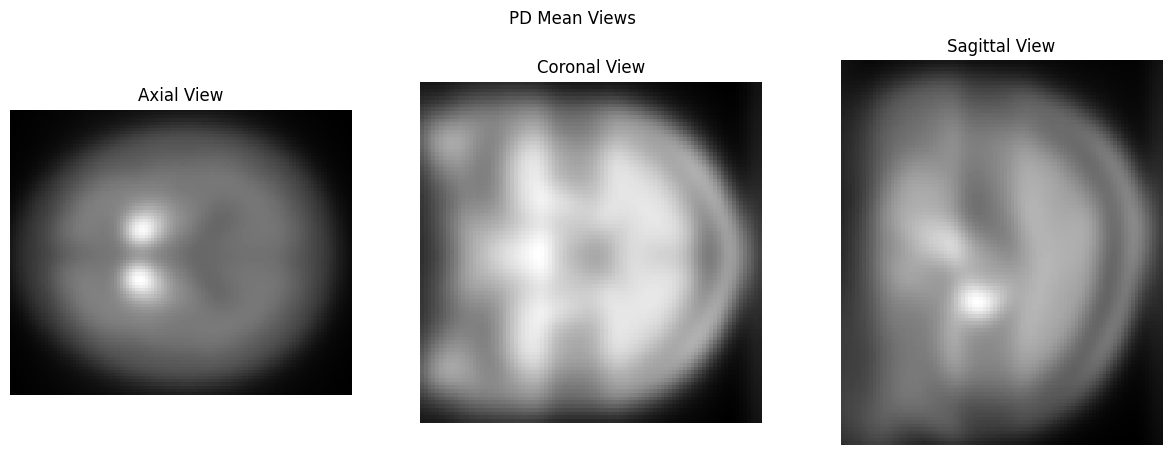

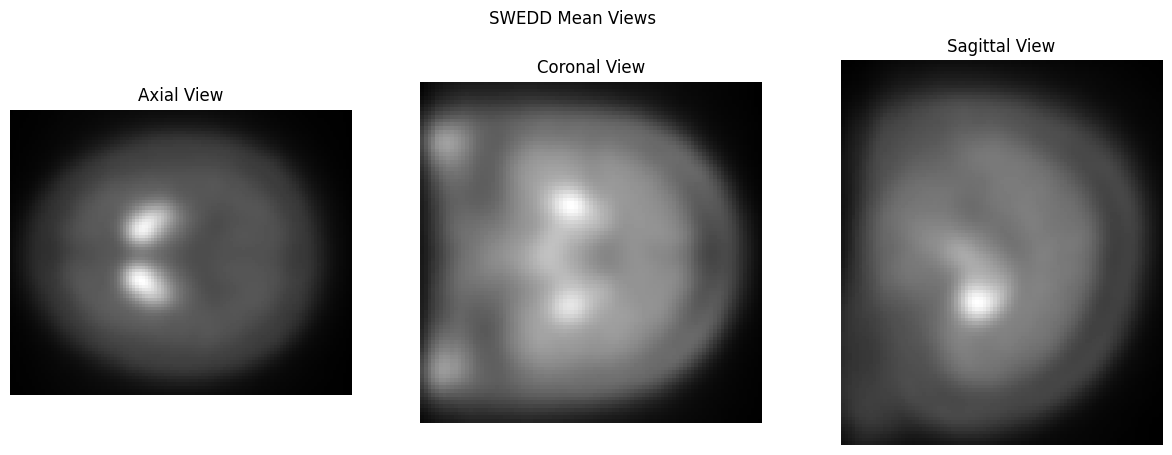

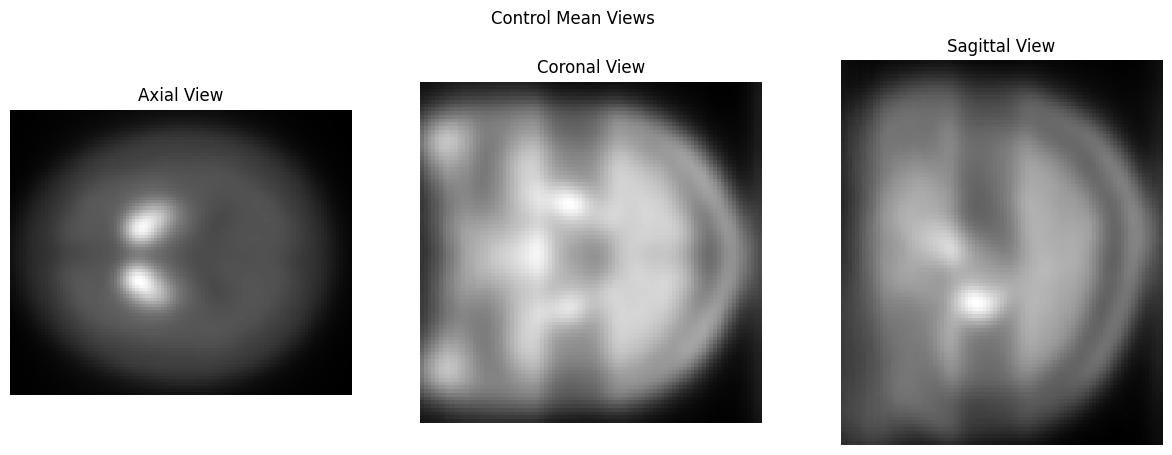

In [27]:
# Cell 12: Plot the mean views for each group
for label in group_labels.values():
    mean_img = mean_sums[label]
    plot_mean_views(mean_img, title_prefix=label)

In [36]:
# Cell 12: Plot the mean views for each group
for label in group_labels.values():
    mean_img = mean_sums[label]
    if mean_img is not None:
        plot_mean_views(mean_img, title_prefix=label)
    else:
        print(f"No mean image available for group: {label}")


No mean image available for group: PD
No mean image available for group: SWEDD
No mean image available for group: Control
